--------------------------

## METEOPOLE_RUNS

He ido anotando qué hace cada celda, y dentro del código he añadido cosas, cambiado o comentado; además de modificar los path.

Primera celda: tiene los import, algunos paths, la configuración de las gráficas y alguna función corta.

In [39]:
import icoscp;
from icoscp.cpb.dobj import Dobj;
import sys
sys.path.append("~/.local/lib/python3.10/site-packages/")
import meteo
from meteo import * # lo he añadido yo a ver si funciona
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import atmos
from datetime import date, datetime, timedelta
import os
import time
# import epygram # no lo usa y no lo tengo
from pathlib import Path
import netCDF4 as nc
import datetime as dt
import matplotlib.dates as mdates
import xarray as xr
import calendar
import seaborn as sns

# Paths
# home = str(Path.home())
figs_path = "D:/Computacional/TFM/figures_meteopole/"

# Para establecer cómo serán las figuras creadas:
matplotlib.rcParams['lines.linewidth'] = 1 # esto se irá cambiando según interese
plt.rcParams['figure.dpi'] = 100 # no entiendo si quieren 500 o 100, he visto ambas
matplotlib.rcParams.update({'font.size': 12}) # estaba a 14 antes
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

def datespan(startDate, endDate, delta=timedelta(days=1)):
    currentDate = startDate
    while currentDate < endDate:
        yield currentDate
        currentDate += delta

def despike(pandas_column, sigma_delta):
   # This function substitutes spikes in data (replaced by nan)
   # The finding criteria for a spike is that contiguous values differ by
   # more than 3*sigma wrt the distribution of series of differences between consecutive values
   delta_z_abs=np.abs(stats.zscore(pandas_column.diff(1),nan_policy='omit'))
   delta_z_abs[0]=0 # Make first value zero instead of nan
   pandas_column_filtered=pandas_column.where(delta_z_abs<sigma_delta, np.nan)
   return pandas_column_filtered

def reduce_pres(pandas_column,station_height):
    #This function reduces pressure in Pa from surface to station height
    #It assumes a pressure gradient of 100 Pa each 9m
    pandas_column_reduced=pandas_column-100*station_height/9
    return pandas_column_reduced

def fieldseries(field,fieldname):
    #function for getting timeseries data from netcdf field and put it in a dataframe with datetime as index
    OUTPUT=pd.DataFrame({'DATETIME': field.validity.get(), fieldname:field.data })
    OUTPUT.set_index('DATETIME',inplace=True)
    return OUTPUT

La siguiente celda crea el DataFrame "OBSERVATIONS1", que son los datos válidos del archivo 'Meteopole_BNR/forcing_run/CNRM_MTO_L2A-30min-Mean_2017_1Y_V1.00.nc'.\
Los nombres de las variables salen por pantalla.

In [40]:
#Rewrite forcing for 10m temperature instead of 2m temperature
station_name='Meteopole' #Select between Norunda, Svartberget, Hyltemossa, Bilos(FR)
write_forcing_wup='no'   #Set to yes for writing forcing in files
write_forcing_run='no'   #Set to yes for writing forcing in files
concatenate_daily_fluxes='no'

limcr_inf=0.5    #lower closure rate limit for include SEB data in validation
limcr_sup=1.5    #upper limit for include SEB data in validation
#Common parameters for Params_config.txt in the three sites
delta_t=1800
Use_Scan='no' #Evaluate energy storage in the canopy
filter_HLE='yes'  #Decide if filter some dates with bad quality data from visual inspection (by Meto)

FOR_PATH='D:/Computacional/TFM/Meteopole_BNR/forcing_run/'

if station_name=='Meteopole':
#define tower levels:
 lev1='2'
 lev2='10'
#Define height, coordinates, levels for Wind, Temperature, etc for Params_config: lat=60.08000000
 lat=60.08333
 lon=17.48333
 alt=46.0
 height_T=10
 height_V=10
 height_Tval=2
 height_Vval=2
 grass_height=0.2  #First order approx is continuous value through the year (taken from namelist)
 height_flux=3.5
 LAI=1.75
 file_netcdf='D:/Computacional/TFM/Meteopole_BNR/forcing_run/CNRM_MTO_L2A-30min-Mean_2017_1Y_V1.00.nc'
 # ds = nc.Dataset()
 # Load the NetCDF file using xarray
 ds = xr.open_dataset(file_netcdf)
 # Create a Pandas DataFrame to store the data
 OBSERVATIONS1 = pd.DataFrame()

# Determine the variable names that meet the criteria
 valid_variable_names = []
 # writing of T10m and Q10m forcings (These initial forcings have to be cleaned from nans)   
 for var_name in ds.variables:
  # print(var_name) # por ahora me estorba
  data = ds[var_name]
  if len(data.dims) == 1 and len(data) > 100:
   valid_variable_names.append(var_name)

 print('These are the variables stored in OBSERVATIONS1:')
# Loop through the valid variables and add their data to the DataFrame
 for variable_name in valid_variable_names:
  print(variable_name)
  data = ds[variable_name].to_pandas()
  data.index=ds.variables['time'][:]
  OBSERVATIONS1[variable_name] = data

 print('')
 #Convert T and Q to SURFEX output units
 OBSERVATIONS1['T10M']=OBSERVATIONS1['T10M']+273.15
 print('Shape of T10M:',OBSERVATIONS1['T10M'].shape)  
 OBSERVATIONS1['Q10M']=OBSERVATIONS1['Q10M']*0.001
 # print(OBSERVATIONS1['Q10M'].shape)
 OBSERVATIONS1['T2M']=OBSERVATIONS1['T2M'][:]+273.15
 # print(OBSERVATIONS1['T2M'].shape)  
 OBSERVATIONS1['Q2M']=OBSERVATIONS1['Q2M'][:]*0.001
 # print(OBSERVATIONS1['Q2M'].shape)
    
#Write forcing if needed    
 if write_forcing_run=='yes':
  os.chdir(FOR_PATH)  
  with open('Forc_TA.txt', "w") as file:
   for value in OBSERVATIONS1['T10M']:
        file.write("%.6f\n" % value)    
  with open('Forc_QA.txt', "w") as file:
   for value in OBSERVATIONS1['Q10M']:
        file.write("{:.8e}\n".format(value))

 if  concatenate_daily_fluxes=='yes':
  date = '2017'
  datafolder = 'D:/Computacional/TFM/Meteopole_BNR/validation_fluxes/MeteoPoleFlux_2017_flux/'
  os.chdir(datafolder)
  filename_prefix = 'CNRM_EP-Eddy-Covariance_L2'
  in_filenames_obs = filename_prefix
  out_filename_obs = 'CAT_' + date + filename_prefix + date+'.nc'

  # Concatenate multiple days
  if not os.path.exists(datafolder + out_filename_obs):
    print("creation of file: ", out_filename_obs)
    os.system('''
        cd {0}
        ncrcat {1}*.nc -o {2}
        '''.format(datafolder, in_filenames_obs, out_filename_obs))
    
# Generate T2M H2M columns for validation. Read them from previous forcing level at 2m (to avoid nans) 
T2M=pd.read_csv(FOR_PATH+'Forc_TA'+'.txt_2m',header=None).values
Q2M=pd.read_csv(FOR_PATH+'Forc_QA'+'.txt_2m',header=None).values
T10M=pd.read_csv(FOR_PATH+'Forc_TA'+'.txt',header=None).values
Q10M=pd.read_csv(FOR_PATH+'Forc_QA'+'.txt',header=None).values

#Substitute TQ at 2,10m to avoid nans
OBSERVATIONS1['T10M']=T10M
OBSERVATIONS1['Q10M']=Q10M
OBSERVATIONS1['T2M']=T2M
OBSERVATIONS1['Q2M']=Q2M
OBSERVATIONS1['T_SURF']=OBSERVATIONS1['T_SURF']+273.15
OBSERVATIONS1['HU10M']=OBSERVATIONS1['H10M']*0.01
OBSERVATIONS1['HU2M']=OBSERVATIONS1['H2M']*0.01

These are the variables stored in OBSERVATIONS1:
time
SOIL_HEAT_FLUX
SWUP
SWD
LWUP
LWD
SW_DIFFUS
P
T2M
H2M
Q2M
T10M
H10M
Q10M
CUMUL_RR
T_SURF
DEW
DD_10M
FF_10M

Shape of T10M: (17520,)


La siguiente celda crea el DataFrame "OBSERVATIONS", que son los datos válidos del archivo 'Meteopole_BNR/validation_fluxes/MeteoPoleFlux_2017_flux/CAT_2017CNRM_EP-Eddy-Covariance_L22017.nc'. Al parecer es la base de datos de un anemómetro sónico, y le faltan 28 días respecto a los datos anteriores.\
Los nombres de las variables salen por pantalla.

In [41]:
# Read flux data from sonic anemometer database
# This database has quite some missing data (17472 rows instead of 17520)
# Make a pandas dataframe with validation variables (28 may missing)
HOMEFOLDER='D:/Computacional/TFM/Meteopole_BNR/'
OBSFOLDER='D:/Computacional/TFM/Meteopole_BNR/validation_fluxes/MeteoPoleFlux_2017_flux/'
FLUXDATA='CAT_2017CNRM_EP-Eddy-Covariance_L22017.nc'

# Load the NetCDF file using xarray
ds = xr.open_dataset(OBSFOLDER+FLUXDATA)
# Create a Pandas DataFrame to store the data
OBSERVATIONS = pd.DataFrame()

print('These are the variables stored in OBSERVATIONS:')
# Determine the variable names that meet the criteria
valid_variable_names = []
for variable in ds.data_vars:
    data = ds[variable]
    if len(data.dims) == 1 and len(data) > 10:
        valid_variable_names.append(variable)
        print(variable)

# Loop through the valid variables and add their data to the DataFrame
for variable_name in valid_variable_names:
    data = ds[variable_name].to_pandas()
    data.index=ds.variables['time'][:]
    OBSERVATIONS[variable_name] = data

print('')
print('Shape of T10M:',OBSERVATIONS['u'].shape) 

These are the variables stored in OBSERVATIONS:
u
v
w
ws
wd
ws_max
virt_temp
air_temp
rh
dew_temp
air_density
air_heat_capacity
e
h2o_mixing_ratio
co2_mixing_ratio
tau
tau_qc
tau_err
H
H_qc
H_err
LE
LE_qc
LE_err
bowen_ratio
h2o_flux
h2o_flux_qc
h2o_flux_err
co2_flux
co2_flux_qc
co2_flux_err
h2o_molar_density
co2_molar_density
u_star
TKE
L
z_minus_d_over_L
u_var
v_var
w_var
sonic_air_temp_var
u_spikes
v_spikes
w_spikes
ts_spikes
h2o_spikes
co2_spikes
w_ts_cov
w_h2o_cov
w_co2_cov
footprint
used_record
h2o_timelag
co2_timelag

Shape of T10M: (17472,)


Ahora se nombran los experimentos, por ahora están el difusivo de referencia y el difusivo con DSL, pero habrá que añadir el MEB (Multi Energy Balance) para referencia y DSL.

In [42]:
#Define experiment name
exps=['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

La siguiente celda crea un DataFrame llamado MPOLE_MOD, ya para el año 2017. Contiene los datos de distintas variables a lo largo de este año, para todos los experimentos en "exp". En el proceso quita variables por no cumplir criterios, ahora se ven por pantalla aunque preferiría que no. Sí voy a mostrar el inicio del DataFrame final.\
Los datos de MPOLE_MOD vienen de todos los experimentos y para los archivos '/run/ISBA_DIAGNOSTICS.OUT.nc' y '/run/ISBA_PROGNOSTIC.OUT.nc'.\
Es decir, son las variables en los archivos de diagnóstico y de pronóstico de Surfex.

In [43]:
MPOLE_MOD=pd.DataFrame()
datetime_start = dt.datetime(2017,1,1)
for exp in exps:
    #Load variables in diagnostic surfex file:
    file=HOMEFOLDER+exp+'/run/ISBA_DIAGNOSTICS.OUT.nc'
    ds = xr.open_dataset(file,decode_times=False)
    for field in ['H_P10','LE_P10','T2M_ISBA','W10M_ISBA','Q2M_ISBA','HU2M_ISBA','CD_P10','CH_P10',
                  'CQ_P10','RI_P10','FMU_P10','FMV_P10','TG1_ISBA','SWD_P10', 'SWU_P10','LWD_P10',
                  'LWU_P10','TSWI1_P10','TSWI2_P10','TSWI3_P10','TSWI4_P10','LEV_P10','LEG_P10']:
     print(field,exp)
     try:    
      MPOLE_MOD[field.split('_')[0]+'_'+exp] = ds[field].data[:, ...].ravel()
     except:
      print('failed')
     pass
    
    #Load variables in prognostic surfex file:    
    file=HOMEFOLDER+exp+'/run/ISBA_PROGNOSTIC.OUT.nc'
    ds = xr.open_dataset(file,decode_times=False)
    for field in ['LMOP10','BETAHFP10','Z0MP10']:
     print(field,exp)
     try:    
      MPOLE_MOD[field.split('_')[0]+'_'+exp] = ds[field].data[:, ...].ravel()
     except:
      print('failed')
     pass
    #Convert LMOP5 to z/L parameter
    for field in ['LMOP10']:
     print(field,exp)
     try:
      MPOLE_MOD['Z'+field+'_'+exp]=height_flux/MPOLE_MOD.loc[:,[field+'_'+exp]]
     except:
      print('failed')
     pass

    #Read TG1 or TC and store it as surface temperature depending if FR or MEB
    for field in ['TCP10']:
     print(field,exp)
     if 'FR' in exp:
      field='TG1P5'
     try:
      MPOLE_MOD.loc[:,['TSEFF_'+exp]] = ds[field].data[:, ...].ravel()
     except:
      print('failed')
     pass
    
MPOLE_MOD['minutes']=ds['time'].data[:, ...].ravel()       
MPOLE_MOD['DATETIME'] = datetime_start+pd.TimedeltaIndex(MPOLE_MOD.minutes, unit='m')
MPOLE_MOD.set_index('DATETIME',inplace=True)
MPOLE_MOD.head(2)

H_P10 DIF_REF
LE_P10 DIF_REF
T2M_ISBA DIF_REF
W10M_ISBA DIF_REF
Q2M_ISBA DIF_REF
HU2M_ISBA DIF_REF
CD_P10 DIF_REF
failed
CH_P10 DIF_REF
failed
CQ_P10 DIF_REF
failed
RI_P10 DIF_REF
FMU_P10 DIF_REF
FMV_P10 DIF_REF
TG1_ISBA DIF_REF
SWD_P10 DIF_REF
SWU_P10 DIF_REF
LWD_P10 DIF_REF
LWU_P10 DIF_REF
TSWI1_P10 DIF_REF
TSWI2_P10 DIF_REF
TSWI3_P10 DIF_REF
TSWI4_P10 DIF_REF
LEV_P10 DIF_REF
LEG_P10 DIF_REF
LMOP10 DIF_REF
failed
BETAHFP10 DIF_REF
failed
Z0MP10 DIF_REF
failed
LMOP10 DIF_REF
failed
TCP10 DIF_REF
failed
H_P10 DIF_DSL
LE_P10 DIF_DSL
T2M_ISBA DIF_DSL
W10M_ISBA DIF_DSL
Q2M_ISBA DIF_DSL
HU2M_ISBA DIF_DSL
CD_P10 DIF_DSL
failed
CH_P10 DIF_DSL
failed
CQ_P10 DIF_DSL
failed
RI_P10 DIF_DSL
FMU_P10 DIF_DSL
FMV_P10 DIF_DSL
TG1_ISBA DIF_DSL
SWD_P10 DIF_DSL
SWU_P10 DIF_DSL
LWD_P10 DIF_DSL
LWU_P10 DIF_DSL
TSWI1_P10 DIF_DSL
TSWI2_P10 DIF_DSL
TSWI3_P10 DIF_DSL
TSWI4_P10 DIF_DSL
LEV_P10 DIF_DSL
LEG_P10 DIF_DSL
LMOP10 DIF_DSL
failed
BETAHFP10 DIF_DSL
failed
Z0MP10 DIF_DSL
failed
LMOP10 DIF_DSL
failed
TCP

,H_DIF_REF,LE_DIF_REF,T2M_DIF_REF,W10M_DIF_REF,Q2M_DIF_REF,HU2M_DIF_REF,RI_DIF_REF,FMU_DIF_REF,FMV_DIF_REF,TG1_DIF_REF,...,LWD_MEB_DSL,LWU_MEB_DSL,TSWI1_MEB_DSL,TSWI2_MEB_DSL,TSWI3_MEB_DSL,TSWI4_MEB_DSL,LEV_MEB_DSL,LEG_MEB_DSL,TSEFF_MEB_DSL,minutes
DATETIME,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:30:00,21.796626,0.876751,277.350341,0.667453,0.004751,0.931674,-0.867106,-0.0,-0.007160,279.639729,...,331.245662,342.894826,0.358869,0.343620,0.279638,0.270396,0.947799,0.0,278.452066,30.0
2017-01-01 01:00:00,20.835360,0.814994,277.122593,0.727277,0.004711,0.938575,-0.836230,-0.0,-0.008407,279.328860,...,330.564784,343.186661,0.343195,0.336592,0.287546,0.271548,1.127195,0.0,278.506841,60.0


Ahora se hacen dos cosas, por una parte se crean y guardan imágenes de las series temporales de forzamientos, que vienen de 'forcing_run', se imprimen por pantalla las disitntas variables.\
Se imprimían antes la cantidad de nans, infs y zeros de cada serie, pero lo he comentado. Se puede ver también visualmente en las gráficas.\
Las imágenes se guardan en 'figures' con el nombre 'Meteopole_Forc_[variable].png'

Por otra parte, se crea el DataFrame MPOLE, es es la concatenación de MPOLE_MOD, OBSERVATIONS y OBSERVATIONS1.

In [44]:
#Load forcings into the pandas dataframe. Plot timeseries just in case.
#I skip the first value which corresponds to 00:00
forcing_vars=['Forc_CO2','Forc_DIR','Forc_PS','Forc_RAIN','Forc_SNOW','Forc_WIND','Forc_DIR_SW','Forc_LW','Forc_QA','Forc_SCA_SW','Forc_TA']
forcing_names=['Near surface CO2 concentration', 'Wind direction', 'Atmospheric pression', 'Rain', 'Snow precipitation', 'Wind speed',
               'Direct short-wave radiation', 'Long-wave radiation', 'Atmospheric humidity', 'Diffuse short-wave radiation', 'Atmospheric temperature']
forcing_units=['kg/m3', 'W/m2', 'Pa', 'kg/m2/s', 'kg/m2/s', 'm/s', 'W/m2', 'W/m2', 'kg/kg', 'W/m2', 'K']
FORPATH='D:/Computacional/TFM/Meteopole_BNR/forcing_run/'
i = 0

print('These are the forcing variables:')
for item in forcing_vars:
 MPOLE_MOD[item]=pd.read_csv(FORPATH+item+'.txt',header=None).values[1:]
 print(item)
 # print(item, 'with '+ str(MPOLE_MOD[item].isna().sum())+ 'nans')
 # print(item, 'with '+ str((MPOLE_MOD[item] == np.inf).sum()) + 'infs')
 # print(item, 'with '+ str((MPOLE_MOD[item] == 0).sum())+ 'zeros')
 fig, axs = plt.subplots(figsize=(16, 3)) # inicialmente estaba a (17,5), luego (12,4)
 MPOLE_MOD[item].plot(ax=axs,label=item+'no_filter')
 axs.set_ylabel(str(item)+' ('+str(forcing_units[i])+')')
 axs.set_xlabel('')
 plt.title(forcing_names[i]+' - Meteopole 2017')
 fig.savefig(figs_path+station_name+'_'+item+'.png',facecolor='white')
 plt.close()
 i+=1

MPOLE_MOD['Forc_SW']=MPOLE_MOD.Forc_DIR_SW+MPOLE_MOD.Forc_SCA_SW
print('Forc_SW') # este se ha añadido a los originales
# Merge datasets according to the datetime index
MPOLE=pd.concat([MPOLE_MOD,OBSERVATIONS,OBSERVATIONS1],axis=1)

These are the forcing variables:
Forc_CO2
Forc_DIR
Forc_PS
Forc_RAIN
Forc_SNOW
Forc_WIND
Forc_DIR_SW
Forc_LW
Forc_QA
Forc_SCA_SW
Forc_TA
Forc_SW


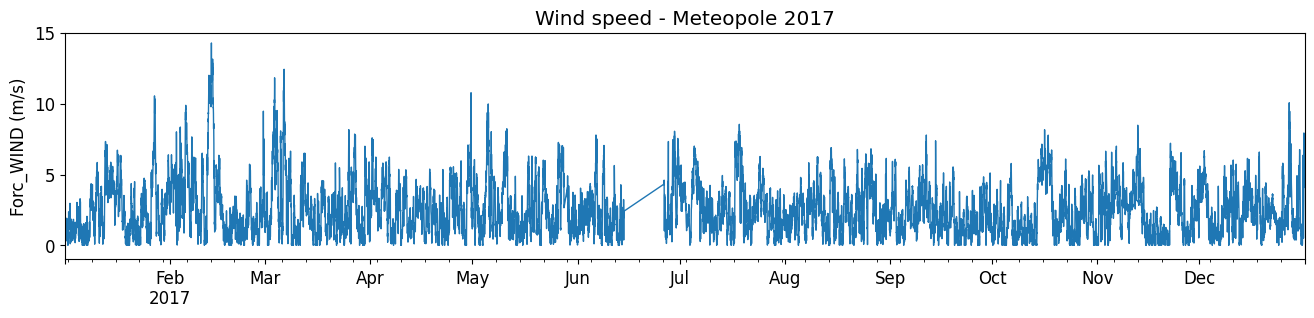

In [56]:
MPOLE_MOD[item]=pd.read_csv('D:/Computacional/TFM/Meteopole_BNR/forcing_run/Forc_WIND'+'.txt',header=None).values[1:]
fig, axs = plt.subplots(figsize=(16, 3))
# gg = MPOLE_MOD['Forc_QA']*1000
MPOLE_MOD['Forc_WIND'].plot(ax=axs,label='Forc_WIND'+'no_filter')
axs.set_ylabel('Forc_WIND (m/s)')
axs.set_xlabel('')
axs.set_ylim([-1, 15])
plt.title('Wind speed - Meteopole 2017') # yeeha
fig.savefig(figs_path+'prueba'+'.png',facecolor='white')
plt.show()

Las gráficas guardadas son las series temporales de forzamiento. Aquí tenemos qué son cada una y qué unidades tiene. Los txt son para todo el dominio pero imagino que solo los sacamos para Meteopole.

The forcing parameters are:
- Atmospheric temperature: Forc_TA.txt / Forc_TA.bin (K)
- Atmospheric humidity: Forc_QA.txt / Forc_QA.bin (kg/kg)
- Atmospheric pression: Forc_PS.txt / Forc_PS.bin (Pa)
- Rain : Forc_RAIN.txt / Forc_RAIN.bin (kg/m2/s)
- Snow precipitation: Forc_SNOW.txt / Forc_SNOW.bin (kg/m2/s)
- Wind speed: Forc_WIND.txt / Forc_WIND.bin (m/s)
- Wind direction: Forc_DIR.txt / Forc_DIR.bin (degrees from N, clockwise)
- Long-wave radiation: Forc_LW.txt / Forc_LW.bin (W/m2)
- direct short-wave radiation: Forc_DIR_SW.txt / Forc_DIR_SW.bin (W/m2)
- diffuse short-wave radiation: Forc_SCA_SW.txt / Forc_SCA_SW.bin (W/m2)
- near surface CO2 concentration: Forc_CO2.txt / Forc_CO2.bin (kg/m3)\

The Forc_... files contain a line by forcing time step. This line contains the value of the forcing
parameters for each point of the user domain.

Vemos que los forzamientos de wind direction y snow son nulos para casi todo el recorrido. 

La siguiente celda añade algunas variables a MPOLE haciendo uso de otras ya existentes. Las variables que añade son para evaluar el 'canopy storage'.

In [57]:
#Evaluate canopy storage
MPOLE.Tslope = pd.Series(np.diff(MPOLE.T_SURF), MPOLE.index[:-1], name='slope')/delta_t;
MPOLE.Qslope = pd.Series(np.diff(MPOLE.Q2M), MPOLE.index[:-1], name='slope')/delta_t;

cp=1004 # J Kg^-1 K-¹
Lv=2.5E6 # J/Kg
cveg=2650 # Kg^-1 K-¹
rho_veg=1.67 # kg m^-3

MPOLE['rhoa']=meteo.rhov(MPOLE.T_SURF,MPOLE.Forc_PS)  # 2m is the closer to canopy temperature, but... rhov
MPOLE['S_T']=cp*MPOLE['rhoa']*grass_height*MPOLE.Tslope
MPOLE['S_veg']=cveg*rho_veg*grass_height*MPOLE.Tslope
MPOLE['S_q']=Lv*MPOLE['rhoa']*grass_height*MPOLE.Qslope

#Filter Scan for outliers if not nullified
nullify_Scan=1
if Use_Scan=='no':
 nullify_Scan=0
if nullify_Scan==1:
 #Cleaning of datasets for spikes which can degradate the closure scheme
 fields_to_smooth=['S_q','S_veg','S_T']
 for field in fields_to_smooth:
  #First despike data when the jump exceeds 3 times the sigma of the jumps distribution.
  MPOLE[field]=despike(MPOLE[field],3)
  #Then remove data where it exceeds 3 times de sigma of the distribution
  MPOLE[field]=MPOLE[field].where(np.abs(stats.mstats.zscore(MPOLE[field],nan_policy='omit'))< 3, np.nan)
  #And fill nans with contiguous data
  MPOLE[field]=MPOLE[field].fillna(method='bfill').fillna(method='ffill')
#Final Scan value is the sum of the 3 components.
MPOLE['S_can']=(MPOLE['S_T']+MPOLE['S_q']+MPOLE['S_veg'])*nullify_Scan


C:\Users\begon\AppData\Local\Temp/ipykernel_11960/1285537894.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  MPOLE.Tslope = pd.Series(np.diff(MPOLE.T_SURF), MPOLE.index[:-1], name='slope')/delta_t;
C:\Users\begon\AppData\Local\Temp/ipykernel_11960/1285537894.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  MPOLE.Qslope = pd.Series(np.diff(MPOLE.Q2M), MPOLE.index[:-1], name='slope')/delta_t;


Ahora añadimos las columnas USTAR a MPOLE. USTAR es 'shear velocity', que se traduce como "velocidad de fricción" en el contexto de la dinámica de fluidos. En meteorología y oceanografía, USTAR es una medida de la velocidad a la cual se produce la fricción del viento sobre una superficie, como la superficie del suelo o del agua

In [58]:
#Generate USTAR.
#Generate z/L parameter for all experiments (since LMOP5 only applies to RSL experiments)
#For temperature, I use T2m diagnostic, but it should actually be T at forcing height, right?

for exp in exps:
    #Now I add USTAR columns although we don't have validation data. I use temperature forcing at 10m to 
    #evaluate air density vector.
    for field in ['USTAR']:
     rhos=atmos.calculate('rho', T=MPOLE['Forc_TA'], p=1e5, rv=0.)
     print(field,exp)
     try:
      MPOLE.loc[:,[field.split('_')[0]+'_'+exp]]=np.sqrt(np.sqrt((MPOLE['FMU_'+exp]*MPOLE['FMU_'+exp]+MPOLE['FMV_'+exp]*MPOLE['FMV_'+exp]))/rhos)
     except:
      print('failed')
     pass
     print('zlmo general',exp)
     try:
      MPOLE.loc[:,['ZLMO_'+exp]]=-height_T/(rhos*cp*(MPOLE['USTAR_'+exp]**3*MPOLE['Forc_TA']/(0.41*9.81*MPOLE['H_'+exp])))
     except:
      print('failed general ZLMO')

USTAR DIF_REF
zlmo general DIF_REF
USTAR DIF_DSL
zlmo general DIF_DSL
USTAR MEB_REF
zlmo general MEB_REF
USTAR MEB_DSL
zlmo general MEB_DSL


Seguimos añadiendo/modificando/suavizando variables de MPOLE.

In [59]:
#Evaluate some observed turbulent quantities

#In dataset with some days filtered, and H,LE, despiked, nan filled...
MPOLE['Cd']=(MPOLE.u_star.clip(lower=0.05)/np.abs(MPOLE.Forc_WIND.clip(lower=0.1)))**2
MPOLE['Ch']=-(MPOLE.H)/(cp*MPOLE.rhoa*np.abs(MPOLE.Forc_WIND.clip(lower=0.1))*(MPOLE.Forc_TA-MPOLE.T_SURF))
MPOLE['Cq']=-(MPOLE.LE)/(Lv*MPOLE.rhoa*np.abs(MPOLE.Forc_WIND.clip(lower=0.1))*(MPOLE.Forc_QA-MPOLE.Q2M))

#MPOLE['Cd']=despike(MPOLE['Cd'],3)
#MPOLE['Ch']=despike(MPOLE['Ch'],3)
#MPOLE['Cq']=despike(MPOLE['Cq'],3)

MPOLE['betaHF']=(MPOLE.u_star.clip(lower=0.05)/MPOLE.Forc_WIND.clip(lower=0.1))

Seguimos añadiendo/modificando/suavizando variables de MPOLE.

In [60]:
#Cleaning of datasets for spikes which can degradate the closure scheme
fields_to_smooth=['H','LE','u_star'] #,'Cd','Ch','Cq','betaHF'
for field in fields_to_smooth:
 #First despike data when the jump exceeds 3 times the sigma of the jumps distribution.
 MPOLE[field]=despike(MPOLE[field],3)
 #Then remove data where it exceeds 3 times de sigma of the distribution
 MPOLE[field]=MPOLE[field].where(np.abs(stats.mstats.zscore(MPOLE[field],nan_policy='omit'))< 3, np.nan)
 #And fill nans with contiguous data
 MPOLE[field]=MPOLE[field].fillna(method='bfill').fillna(method='ffill')

Ahora se crea una imagen con la regresión lineal del ajuste de radiación. Para ello crea variables en MPOLE y crea un nuevo DataFrame llamado 'MPOLE_closing', donde incluye 10 de las variables de MPOLE. La regresión lineal enfrenta la suma del flujo de calor latente y calor sensible frente a la radiación neta menos el flujo radiativo del suelo. Es decir, está evaluando el balance de energía en superficie.

"Closure rate" puede traducirse como "velocidad/tasa de convergencia". En el contexto de regresión lineal, la tasa de convergencia se relaciona con la velocidad a la que los parámetros del modelo convergen hacia los valores óptimos que mejor ajustan los datos observados.

In [61]:
#Evaluate closure rate from the regresion line of the scatterplot

#Station_SEB_run=Station_SEB_run[['Forc_DIR_SW','SW_OUT','Forc_LW','LW_OUT','G_2','H','H_UNCLEANED', 'LE', 'LE_UNCLEANED','USTAR']]
#Drop rows where there are NAN values
#Station_SEB_run=Station_SEB_run.dropna(axis=0)

MPOLE['Rn-G']=MPOLE.Forc_LW-MPOLE.LWUP+MPOLE.Forc_SW-MPOLE.SWUP-MPOLE.SOIL_HEAT_FLUX
MPOLE['Rn-G-S_can']=MPOLE['Rn-G']-MPOLE['S_can']
MPOLE['H+LE']=MPOLE.H+MPOLE.LE

MPOLE_closing = MPOLE[['Rn-G','H','LE','H+LE','Rn-G-S_can','S_can','S_veg','S_T','S_q','u_star']].copy()

#remove nans
print('Shape of MPOLE_closing:', MPOLE_closing.shape)
MPOLE_closing    =  MPOLE_closing.dropna(axis=0)

# get coeffs of linear fit
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(MPOLE_closing['Rn-G'],MPOLE_closing['H+LE'])

# use line_kws to set line label for legend
fig = plt.figure(figsize=(10,7)) ###
ax = sns.regplot(x="Rn-G", y="H+LE", data=MPOLE_closing, 
                 scatter_kws={"color":"none","edgecolor":"black","alpha":0.2,"s":10}, 
                 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope1,intercept1), "ls":"--", "color":"grey"})

ax.legend() # plot legend
plt.xlim([-100, 550])
plt.ylim([-100, 550])
plt.title('Closure rate for surface energy balance')
fig.savefig(figs_path+station_name+'_H+LE_Rn-G.png',facecolor='white')
plt.close()

Shape of MPOLE_closing: (17520, 10)


Ahora se corrigen los valores de H y LE de modo que se alcance el malance cada 30 minutos, usando la correción de Bowen. Para ello se añaden también variables a MPOLE_closing y luego redefine el DataFrame. Así, se vuelve a dibujar la regresión lineal del balance de energía en superficie, pero ahora corregido.

Ojo que hay varias opciones para la corrección del Bowen Ratio, las explica y escoge una concreta, no sé si tendría que cambiarla bajo otras circunstancias.

In [62]:
#Evaluate traditional Bowen Ratio
#Now I correct H and LE values so that closure balance is achieved every 30' and a correct bowen ratio is assumed.
#This approach follows Twine et al (2000) or Blaken et al.
#Select type of Bowen Ratio correction
BRcor=3   # 1 for old-style forced closure keeping bowen ratio
          # 2 for old-style forced closure keeping bowen ratio, but based in daily bowen ratios.
          # 3 for forced closure keeping bowen ratio, but including canopy storage in SEB equation
          # 4 for forced closure keeping bowen ratio, but including canopy storage in SEB equation and Bowen_ratio definition

MPOLE_closing['bowen']=MPOLE_closing.H/MPOLE_closing.LE

#Evaluate closure rates from uncleaned or cleaned values of H and LE
MPOLE_closing['closure_rate']=MPOLE_closing['H+LE']/MPOLE_closing['Rn-G']

if BRcor==4 or BRcor==3: #Add Scan into the closure rate evaluation
 MPOLE_closing['closure_rate_cleaned']=MPOLE_closing['H+LE']/MPOLE_closing['Rn-G-S_can']
if BRcor==4:  # Redefine Bowen ratio to include S_i components in the definition.
 MPOLE_closing['bowen']=(MPOLE_closing.H+MPOLE_closing.S_T+MPOLE_closing.S_veg)/(MPOLE_closing.LE+MPOLE_closing.S_q)
if BRcor==2:   # Base bowen ratio in daily values
 MPOLE_closing['bowen']=(MPOLE_closing.resample("D").sum().H/MPOLE_closing.resample("D").sum().LE).resample('0.5H').pad()
if BRcor==1 or BRcor==2:  # Correct H,LE based i Bowen ratio, traditional way
 MPOLE_closing['LE_corrected']=MPOLE_closing['Rn-G']/(1+MPOLE_closing['bowen'])
 MPOLE_closing['H_corrected' ]=MPOLE_closing['bowen']*MPOLE_closing['LE_corrected']
if BRcor==3 or BRcor==4: # Correct H,LE based i Bowen ratio, including Scan in A term
 MPOLE_closing['LE_corrected']=MPOLE_closing['Rn-G-S_can']/(1+MPOLE_closing['bowen'])
 MPOLE_closing['H_corrected' ]=MPOLE_closing['bowen']*MPOLE_closing['LE_corrected']

#Let in MPOLE_closing only columns needed for recomputing and plotting resulting closure:
MPOLE_closing   = MPOLE_closing[['Rn-G','H_corrected','LE_corrected','closure_rate','H+LE']].copy()
    
#replace possible inf values to Na and filter
MPOLE_closing.replace([np.inf, -np.inf], np.nan, inplace=True)
# print(MPOLE_closing.shape)
MPOLE_closing    =  MPOLE_closing.dropna(axis=0)

# Filter outliers (filter out any row where any column's value exceeds <>+- times_sig*sigma)
times_sig=30
z_scores_cleaned = stats.zscore(MPOLE_closing)
abs_z_scores_cleaned = np.abs(z_scores_cleaned)
filtered_entries = (abs_z_scores_cleaned < times_sig).all(axis=1)
print('Number of nans in each variable after correction:')
print(MPOLE_closing.isna().sum())
# print(MPOLE_closing.shape)
MPOLE_closing = MPOLE_closing[filtered_entries]
print('New shape of MPOLE_closing:', MPOLE_closing.shape)

#Now plot again the scatterplot to check for forced SEB closure
MPOLE_closing['Hcor+LEcor']=MPOLE_closing.H_corrected+MPOLE_closing.LE_corrected
slope, intercept, r_value, p_value, std_err = stats.linregress(MPOLE_closing['Rn-G'],MPOLE_closing['Hcor+LEcor'])

fig = plt.figure(figsize=(10,7)) ###
ax = sns.regplot(x="Rn-G", y="Hcor+LEcor", data=MPOLE_closing, 
                 scatter_kws={"color":"black","edgecolor":"black", "alpha":0.9, "s":5}, 
                 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept),"ls":"-", "color":"black"})

ax.legend() # plot legend
plt.xlim([-100, 550])
plt.ylim([-100, 550])
plt.title('Corrected closure rate for surface energy balance')
fig.savefig(figs_path+station_name+'_Hcor+LEcor_Rn-G.png',facecolor='white')
plt.close()

Number of nans in each variable after correction:
Rn-G            0
H_corrected     0
LE_corrected    0
closure_rate    0
H+LE            0
dtype: int64
New shape of MPOLE_closing: (17276, 5)


Representamos las series temporales de los flujos de calor latente y calor sensible corregidos y sin corregir. También se representa el closure rate (CR). Por otra parte, el closure rate se limita ahora entre 0.5 y 1.5, y lo justifica diciendo que que es para cuando se incluyen datos SEB en la validación.

¿Sé qué unidades poner en estas gráficas? ¿O no hace falta?

¿Guardar estas imágenes como se ha hecho con las otras?

Mean closure rates based in 30 min values: 
0.8237285893864319
Mean closure rates based in average fluxes through all dataset:
0.786784790196848


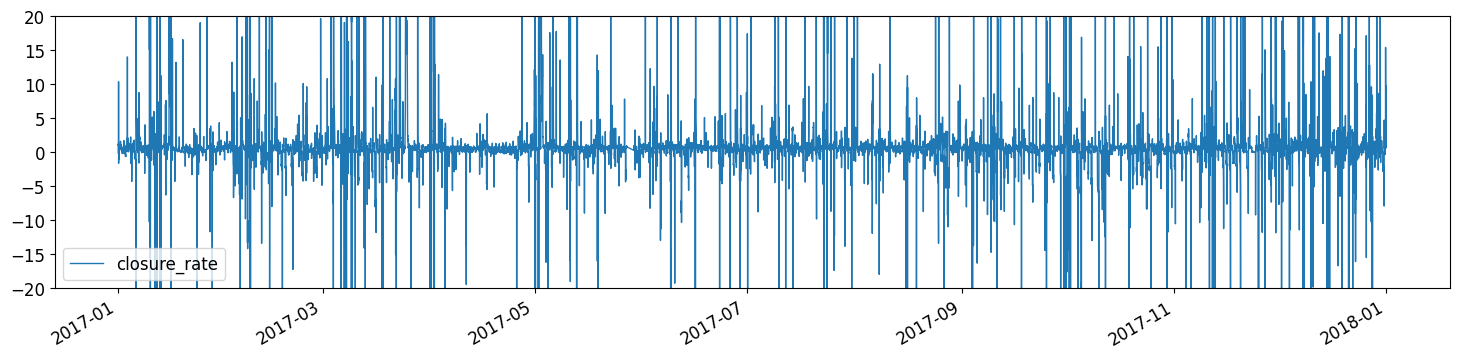

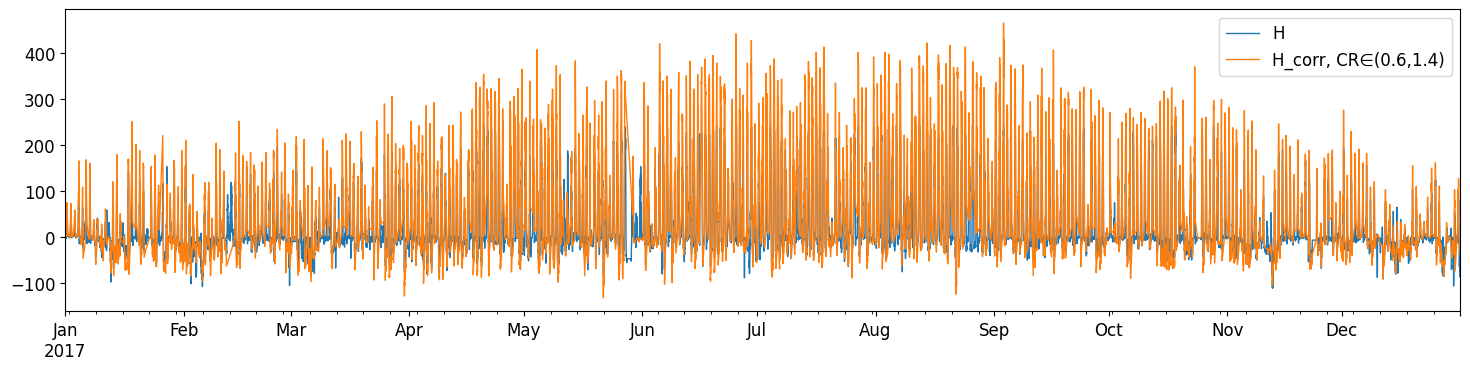

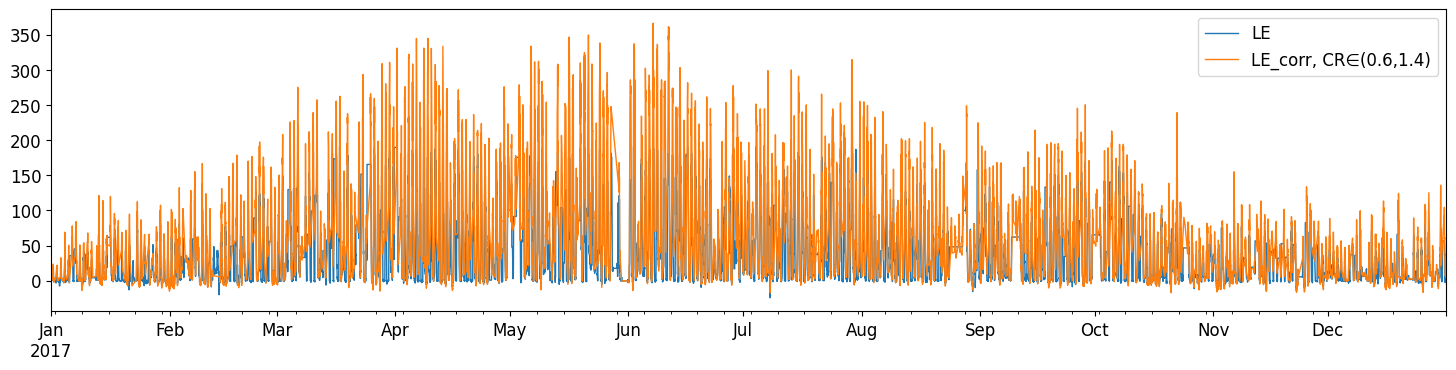

In [63]:
#Plot closure values and resulting corrected H_unc* LE_unc*
fig1, ax1 = plt.subplots(figsize=(18, 4))
MPOLE_closing.closure_rate.plot(ax=ax1)
ax1.legend()
ax1.set_ylim([-20,20]) # sin esto hay valores aislados de hasta 3000, antes ponía [-6,6]

fig2, ax2 = plt.subplots(figsize=(12, 4))
fig3, ax3 = plt.subplots(figsize=(12, 4))
MPOLE.H.plot(ax=ax2,figsize=(18,4),label='H')
MPOLE.LE.plot(ax=ax3,figsize=(18,4),label='LE')

#Here I evaluate the mean closure rate as its average value based in 30' values.
print('Mean closure rates based in 30 min values: ')
print(MPOLE_closing.closure_rate.mean())

#Other way of evaluating mean closure rate, is from average flux values over the whole period:
avg_closure_rate=(MPOLE_closing['H+LE'].mean())/(MPOLE_closing['Rn-G'].mean())
print('Mean closure rates based in average fluxes through all dataset:')
print(avg_closure_rate)

#Final valid SEB data will be restricted to closure rates between limcr_inf and limcr_sup
limcr_inf=0.5       #lower closure rate limit for include SEB data in validation
limcr_sup=1.5       #upper limit for include SEB data in validation
MPOLE_closing=MPOLE_closing[MPOLE_closing.closure_rate<limcr_sup]
MPOLE_closing=MPOLE_closing[MPOLE_closing.closure_rate>limcr_inf]
MPOLE_closing.H_corrected.plot(ax=ax2,figsize=(18,4),label='H_corr, CR∈(0.6,1.4)')
MPOLE_closing.LE_corrected.plot(ax=ax3,figsize=(18,4),label='LE_corr, CR∈(0.6,1.4)')
ax2.legend()
ax3.legend()

Ahora vamos a crear otra serie de gráficas. Como serán mensuales, se crea un DataFrame llamado 'MPOLE_mycycle' con los datos de MPOLE agrupados por mes, de manera que tenemos la media diaria de cada mes. Lo mismo se hace con MPOLE_closing, creando 'MPOLE_closing_mcycle'.

Así, se crean imágenes con una gráfica para cada mes de 2017, donde se representan para todos los experimentos (ahora mismo solo DIF_REF y DIF_DSL) la evolución de una variable concreta. Las variables representadas en esta celda se imprimen por pantalla. Las imágenes se guardan con nombres 'Meteopole_[variable]_[experimentos].png'.

In [14]:
# # Cambiamos a 3 la linewidth y a 14 la letra
# matplotlib.rcParams['lines.linewidth'] = 2.0
# matplotlib.rcParams.update({'font.size': 14})

# #Evaluate monthly diurnal cycles
# MPOLE_mcycle=MPOLE.groupby([(MPOLE.index.month),(MPOLE.index.hour)]).mean()
# MPOLE_closing_mcycle=MPOLE_closing.groupby([(MPOLE_closing.index.month),(MPOLE_closing.index.hour)]).mean()

# # SEB Monthly graphs for Meteopole
# my_list = [x for x in range(1,25)]
# idx = pd.IndexSlice
# print('These are the variables represented and stored in this code:')

# #for field in ['TSWI1','TSWI2','TSWI3','TSWI4','H','LE','LEV','LEG','T2M','W10M','HU2M','CD_ISBA','CH_ISBA','RI','FMU','FMV','TG1','SWD', 'SWU','LWD', 'LWU']:
# # 'averaged drag momentum coefficient','averaged thermal diffusion coefficient'

# names1 = ['total soil wetness index 1','total soil wetness index 2','total soil wetness index 3','total soil wetness index 4', 
#           'sensible heat flux','latent heat flux','vegetation evaporation heat flux','ground evaporation heat flux','temperature at 2 meters',
#           'vertical wind at 10 meters','air relative humidity at 2 meters','averaged richardson number','zonal wind stress',
#           'meridian wind stress','surface temperature 1','downward short wave radiation','upward short wave radiation',
#           'downward long wave radiation','upward long wave radiation']
# units1 = ['-','-','-','-','W/m2','W/m2','W/m2','W/m2','K','m/s','-','-','Pa','Pa','K','W/m2','W/m2','W/m2','W/m2']

# m=0
# for field in ['TSWI1','TSWI2','TSWI3','TSWI4','H','LE','LEV','LEG','T2M','W10M','HU2M','RI','FMU','FMV','TG1','SWD','SWU','LWD','LWU']:
#  print(field+': '+names1[m]+' ('+units1[m]+')')
#  fig = plt.figure(figsize=(18,15)) # al principio (18,15)
#  axes = fig.subplots(nrows=4, ncols=3)
#  max_y = float('-inf')  # Inicializa el máximo global como infinito negativo ###
#  min_y = float('inf')  # Inicializa el mínimo global como infinito positivo ###
#  for i in [0,1,2,3]:
#   for j in [0,1,2]:
#     c=0
#     for exp in exps: # por ejemplo: para ver solo los MEB poner exps[2:], pero ojo los colores
#      axes[i,j].plot(my_list,MPOLE_mcycle[field+'_'+exp].loc[idx[3*i+j+1, 0:23]].values,label=exp,color=colors[c],linestyle=styles[c]) # field+'_'+exp
#      axes[i,j].set_title(calendar.month_name[3*i+j+1])
#      axes[i,j].set_xlim([1,24])
#      axes[i,j].set_xticks([3,6,9,12,15,18,21])
#      axes[i,j].grid(True)
#      max_y = max(max_y, np.max(MPOLE_mcycle[field+'_'+exp].loc[idx[3*i+j+1, 0:23]].values)) ###
#      min_y = min(min_y, np.min(MPOLE_mcycle[field+'_'+exp].loc[idx[3*i+j+1, 0:23]].values)) ###
#      c+=1
#  for i in [0,1,2,3]: ###
#   for j in [0,1,2]: ###
#     axes[i,j].set_ylim([min_y, max_y]) ###
#  lines, labels = fig.axes[-1].get_legend_handles_labels()
#  fig.legend(lines, labels, facecolor='lightgray', loc='lower center',framealpha=1, ncol=4) # loc='center', 'lower center', 'upper right'
#  fig.suptitle(field+': '+names1[m]+' ('+units1[m]+') - Meteopole 2017', fontsize=18, fontweight='bold')
#  m+=1
#  fig.tight_layout()
#  fig.subplots_adjust(bottom=0.06)
#  fig.savefig(figs_path+station_name+'_'+field+'_all.png',facecolor='white') # antes era '_'+exps[0]+'_'+exps[1]+'.png' en vez de '_all.png'
#  plt.close()

Ahora nos vamos a adentrar en la validación vs observación. Es decir, en comparar los experimentos con los valores reales observados. Sacamos el mismo tipo de gráficas que hamos guardado antes, pero ahora salen las líneas de los experimentos y la de las observaciones. Para el caso de H y LE también sale la línea de las observaciones corregidas (esto antes estaba desactivado). 

Las imágenes se guardan con nombres 'Meteopole_[variable]_[experimentos]_OBS.png'

No sé qué es ZLMO, preguntar! Además su gráfica sale muy pocha.

In [15]:
# #Validation vs observations

# #dictionary of modeled vs observed column names. W10M actually refers to 3.5m diagnostics (sonic level)
# my_dict = {'H': 'H', 'LE': 'LE','ZLMO':'z_minus_d_over_L','T2M':'T2M','W10M':'ws','USTAR':'u_star','Q2M':'Q2M',
#            'SWD':'Forc_SW', 'SWU':'SWUP','LWD':'Forc_LW', 'LWU':'LWUP','CD':'Cd','CH':'Ch','CQ':'Cq','HU2M':'HU2M'}
# #for field in ['H','LE','T2M','HU2M','W10M','USTAR','Q2M','SWD', 'SWU','LWD', 'LWU','ZLMO','CD','CH']:

# print('These are the variables represented and stored in this code:')

# names2 = ['sensible heat flux','latent heat flux','temperature at 2 meters','air relative humidity at 2 meters',
#           'vertical wind at 10 meters','shear velocity','air specific humidity at 2 meters','downward short wave radiation','upward short wave radiation',
#           'downward long wave radiation','upward long wave radiation','??']
# units2 = ['W/m2','W/m2','K','-','m/s','m/s','kg/kg','W/m2','W/m2','W/m2','W/m2','??']

# m=0
# for field in ['H','LE','T2M','HU2M','W10M','USTAR','Q2M','SWD', 'SWU','LWD', 'LWU','ZLMO']:
#  ncol = 5
#  print(field+': '+names2[m]+' ('+units2[m]+')')
#  my_list = [x for x in range(1,25)]
#  idx = pd.IndexSlice
#  fig = plt.figure(figsize=(18,15)) # estaba en (15,16)
#  axes = fig.subplots(nrows=4, ncols=3)
#  max_y = float('-inf')  # Inicializa el máximo global como infinito negativo ###
#  min_y = float('inf')  # Inicializa el mínimo global como infinito positivo ###
#  for i in [0,1,2,3]:
#   for j in [0,1,2]:
#     c=0
#     for exp in exps:
#      axes[i,j].plot(my_list,MPOLE_mcycle[field+'_'+exp].loc[idx[3*i+j+1, 0:23]].values,label=exp,color=colors[c],linestyle=styles[c]) # field+'_'+exp
#      max_y = max(max_y, np.max(MPOLE_mcycle[field+'_'+exp].loc[idx[3*i+j+1, 0:23]].values)) ###
#      min_y = min(min_y, np.min(MPOLE_mcycle[field+'_'+exp].loc[idx[3*i+j+1, 0:23]].values)) ###
#      c+=1
#     axes[i,j].plot(my_list,MPOLE_mcycle[my_dict[field]].loc[idx[3*i+j+1, 0:23]].values,label='obs',color=colors[4],linestyle=styles[4]) # field+'_obs'
#     max_y = max(max_y, np.max(MPOLE_mcycle[my_dict[field]].loc[idx[3*i+j+1, 0:23]].values)) ###
#     min_y = min(min_y, np.min(MPOLE_mcycle[my_dict[field]].loc[idx[3*i+j+1, 0:23]].values)) ###
#     c+=1
#     if field=='H' or field=='LE':
#      axes[i,j].plot(my_list,MPOLE_closing_mcycle[my_dict[field]+'_corrected'].loc[idx[3*i+j+1, 0:23]].values,label='obs_cor',color=colors[5],linestyle=styles[5]) # esto
#      # estaba quitado pero lo he vuelto a poner, field+'_obs_cor'
#      max_y = max(max_y, np.max(MPOLE_closing_mcycle[my_dict[field]+'_corrected'].loc[idx[3*i+j+1, 0:23]].values)) ###
#      min_y = min(min_y, np.min(MPOLE_closing_mcycle[my_dict[field]+'_corrected'].loc[idx[3*i+j+1, 0:23]].values)) ###
#      axes[i,j].fill_between(my_list, MPOLE_mcycle[my_dict[field]].loc[idx[3*i+j+1, 0:23]].values, MPOLE_closing_mcycle[my_dict[field]+'_corrected'].loc[idx[3*i+j+1, 0:23]].values, color='gray', alpha=0.15)
#      ncol=6
#     axes[i,j].set_title(calendar.month_name[3*i+j+1])
#     axes[i,j].set_xlim([1,24])
#     axes[i,j].set_xticks([3,6,9,12,15,18,21])
#     axes[i,j].grid()
#  for i in [0,1,2,3]: ###
#   for j in [0,1,2]: ###
#     axes[i,j].set_ylim([min_y, max_y]) ###
#  lines, labels = fig.axes[-1].get_legend_handles_labels()
#  fig.legend(lines, labels, facecolor='lightgray', loc='lower center',framealpha=1,ncol=ncol) # framealpha=0.8
#  fig.suptitle(field+': '+names2[m]+' ('+units2[m]+') - Meteopole 2017', fontsize=18, fontweight='bold')
#  m+=1
#  fig.tight_layout()
#  fig.subplots_adjust(bottom=0.06) # antes estaba hspace=0.5
#  fig.savefig(figs_path+station_name+'_'+field+'_all_OBS.png',facecolor='white')  # antes era '_'+exps[0]+'_'+exps[1]+'_OBS.png' en vez de '_all_OBS.png'
#  plt.close()

Distintas agrupaciones de cosas:

In [64]:
MPOLE_daily=MPOLE.groupby([(MPOLE.index.month),(MPOLE.index.day)]).mean()
MPOLE_hours=MPOLE.groupby([(MPOLE.index.month),(MPOLE.index.day),(MPOLE.index.hour)]).mean() # 8760
MPOLE_mcycle=MPOLE.groupby([(MPOLE.index.month),(MPOLE.index.hour)]).mean()

MPOLE_closing_mcycle=MPOLE_closing.groupby([(MPOLE_closing.index.month),(MPOLE_closing.index.hour)]).mean()
MPOLE_closing_daily=MPOLE_closing.groupby([(MPOLE_closing.index.month),(MPOLE_closing.index.day)]).mean()
# Me falta el 28 de mayo en meteopole, por eso tengo que hacer esto:
for columna in MPOLE_closing_daily.columns.tolist():
 valor_27_mayo = MPOLE_closing_daily.loc[(5, 27), columna]
 valor_29_mayo = MPOLE_closing_daily.loc[(5, 29), columna]
 media_27_29_mayo = (valor_27_mayo + valor_29_mayo) / 2
 MPOLE_closing_daily.loc[(5, 28), columna] = media_27_29_mayo

MPOLE_MOD_daily=MPOLE_MOD.groupby([(MPOLE_MOD.index.month),(MPOLE_MOD.index.day)]).mean()
MPOLE_MOD_hours=MPOLE_MOD.groupby([(MPOLE_MOD.index.month),(MPOLE_MOD.index.day),(MPOLE_MOD.index.hour)]).mean()
MPOLE_MOD_mcycle=MPOLE_MOD.groupby([(MPOLE_MOD.index.month),(MPOLE_MOD.index.hour)]).mean()

In [65]:
MPOLE_daily_sum=MPOLE.groupby([(MPOLE.index.month),(MPOLE.index.day)]).sum()
MPOLE_closing_daily_sum=MPOLE_closing.groupby([(MPOLE_closing.index.month),(MPOLE_closing.index.day)]).sum()
MPOLE_MOD_daily_sum=MPOLE_MOD.groupby([(MPOLE_MOD.index.month),(MPOLE_MOD.index.day)]).sum()

In [66]:
MPOLE_energy=MPOLE.groupby([(MPOLE.index.month),(MPOLE.index.day)]).sum()*1.8 
MPOLE_closing_energy=MPOLE_closing.groupby([(MPOLE_closing.index.month),(MPOLE_closing.index.day)]).sum()*1.8 
MPOLE_MOD_energy=MPOLE_MOD.groupby([(MPOLE_MOD.index.month),(MPOLE_MOD.index.day)]).sum()*1.8 

In [67]:
MPOLE_closing_hours=MPOLE_closing.groupby([(MPOLE_closing.index.month),(MPOLE_closing.index.day),(MPOLE_closing.index.hour)]).sum()

In [68]:
MPOLE_closing.index = pd.to_datetime(MPOLE_closing.index)
full_index = pd.date_range(start='2017-01-01 00:00:00', end='2017-12-31 23:59:59', freq='30T')
MPOLE_closing_reindexed = MPOLE_closing.reindex(full_index)

------------------------------------------------------------

# PROYECTO "SERIES TEMPORALES":
### Con una sola celda sacar todas las posibilidades que quiera cómodamente de gráficas TEMPORALES, que puedan abarcar todo el año o secciones, de los parámetros que quiera, con obs u obs_cor si quiero, acompañada de los forzamientos que quiera (uno o más), y representando los experimentos que quiera entre los 4 que tengo aquí (DIF o MEB, REF o DSL). Estaría bien poder representar también varios parámetros a la vez.

Dibujar H y LE frente a las observaciones pero día a día, en lugar del ciclo diurno mensual, y sobreponer en esas gráficas la precipitación (o tasa de precipitación, que es lo que tienes en la variable de Forzamiento FORC_Rain con la que se alimenta al modelo. Hacerlo para ambos, pero estaba propuesto para ver qué ocurre en Majadas en diciembre (DIF_REF rarete). 

TSWI: ver el ciclo diurno no tiene sentido, menor ver ciclos anuales (dato diario). Así que en esta gráfica saco de los principales parámetros a estudiar las gráficas de evolución anual (en dato por día). Con todos los experimentos juntos.

In [69]:
forcing_vars=['Forc_CO2','Forc_DIR','Forc_PS','Forc_RAIN','Forc_SNOW','Forc_WIND','Forc_DIR_SW','Forc_LW','Forc_QA','Forc_SCA_SW','Forc_TA']
forcing_names=['Near surface CO2 concentration', 'Wind direction', 'Atmospheric pression', 'Rain', 'Snow precipitation', 'Wind speed',
               'Direct short-wave radiation', 'Long-wave radiation', 'Atmospheric humidity', 'Diffuse short-wave radiation', 'Atmospheric temperature']
forcing_units=['kg/m3', 'W/m2', 'Pa', 'kg/m2/s', 'kg/m2/s', 'm/s', 'W/m2', 'W/m2', 'kg/kg', 'W/m2', 'K']
forcing_units_2=['N/A', 'kJ/m2', 'N/A', 'N/A', 'N/A', 'N/A', 'kJ/m2', 'kJ/m2', 'N/A', 'kJ/m2', 'N/A']

# Creo que el diccionario solo es necesario aplicarlo para las observaciones (sin corregir, claro)
my_dict = {'H': 'H', 'LE': 'LE','ZLMO':'z_minus_d_over_L','T2M':'T2M','W10M':'ws','USTAR':'u_star','Q2M':'Q2M',
           'SWD':'Forc_SW', 'SWU':'SWUP','LWD':'Forc_LW', 'LWU':'LWUP','CD':'Cd','CH':'Ch','CQ':'Cq','HU2M':'HU2M'}

field_vars = ['TSWI1','TSWI2','TSWI3','TSWI4','H','LE','LEV','LEG','T2M','W10M','HU2M','RI','FMU','FMV','TG1','SWD','SWU','LWD','LWU','USTAR','Q2M','ZLMO']
# field_names = ['total soil wetness index 1','total soil wetness index 2','total soil wetness index 3','total soil wetness index 4', 
#           'sensible heat flux','latent heat flux','vegetation evaporation heat flux','ground evaporation heat flux','temperature at 2 meters',
#           'vertical wind at 10 meters','air relative humidity at 2 meters','averaged richardson number','zonal wind stress',
#           'meridian wind stress','surface temperature 1','downward short wave radiation','upward short wave radiation',
#           'downward long wave radiation','upward long wave radiation','shear velocity','air specific humidity at 2 meters','??']
field_units = ['-','-','-','-','W/m2','W/m2','W/m2','W/m2','K','m/s','-','-','Pa','Pa','K','W/m2','W/m2','W/m2','W/m2','m/s','kg/kg','??']

field_names = ['total soil wetness index 1','total soil wetness index 2','total soil wetness index 3','total soil wetness index 4', 
          'sensible heat','latent heat','vegetation evaporation heat','ground evaporation heat','temperature at 2 meters',
          'vertical wind at 10 meters','air relative humidity at 2 meters','averaged richardson number','zonal wind stress',
          'meridian wind stress','surface temperature 1','downward short wave radiation','upward short wave radiation',
          'downward long wave radiation','upward long wave radiation','shear velocity','air specific humidity at 2 meters','??']
field_units_2 = ['N/A','N/A','N/A','N/A','kJ/m2','kJ/m2','kJ/m2','kJ/m2','N/A','N/A','N/A','N/A','N/A','N/A','N/A','kJ/m2','kJ/m2','kJ/m2','kJ/m2','N/A','N/A','N/A']


exps=['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']
# ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL', 'obs', 'obs_cor', 'forc']
colors = ['deepskyblue', 'blue', 'orange', 'crimson', 'black', 'grey', 'grey'] # no me decido entre grey y lightblue
styles = ['solid', 'dashed', 'solid', 'dashed', 'dotted', 'dotted', 'solid']

MPOLE_MOD: forzamientos cada media hora (valores base)\
MPOLE_MOD_hours: forzamientos horarios\
MPOLE_MOD_daily: forzamientos diarios
MPOLE_MOD_mcycle: MPOLE_MOD en promedio mensual de cada hora (24 horas para cada mes)

MPOLE: paramentros de las simulaciones y observaciones cada media hora (valores base)\
MPOLE_hours: MPOLE horario\
MPOLE_daily: MPOLE diario\
MPOLE_mcycle: MPOLE en promedio mensual de cada hora (24 horas para cada mes)\
MPOLE_daily_filt: MPOLE_daily pero solo con los valores positivos, por ahora le he dado poco uso y puede que esté mal

MPOLE_closing: observaciones corregidas y otros cálculos cada media hora pero irregular (no podemos sacar el horario) (valores base)\
MPOLE_closing_daily: MPOLE_closing diario\
MPOLE_closing_mcycle: MPOLE_closing en promedio mensual de cada hora (24 horas para cada mes)\
MPOLE_closing_daily_filt: MPOLE_closing_daily pero solo con los valores positivos, por ahora le he dado poco uso y puede que esté mal

MPOLE_closing_reindexed: observaciones corregidas y otros cálculos cada media hora REGULAR (faltan datos)

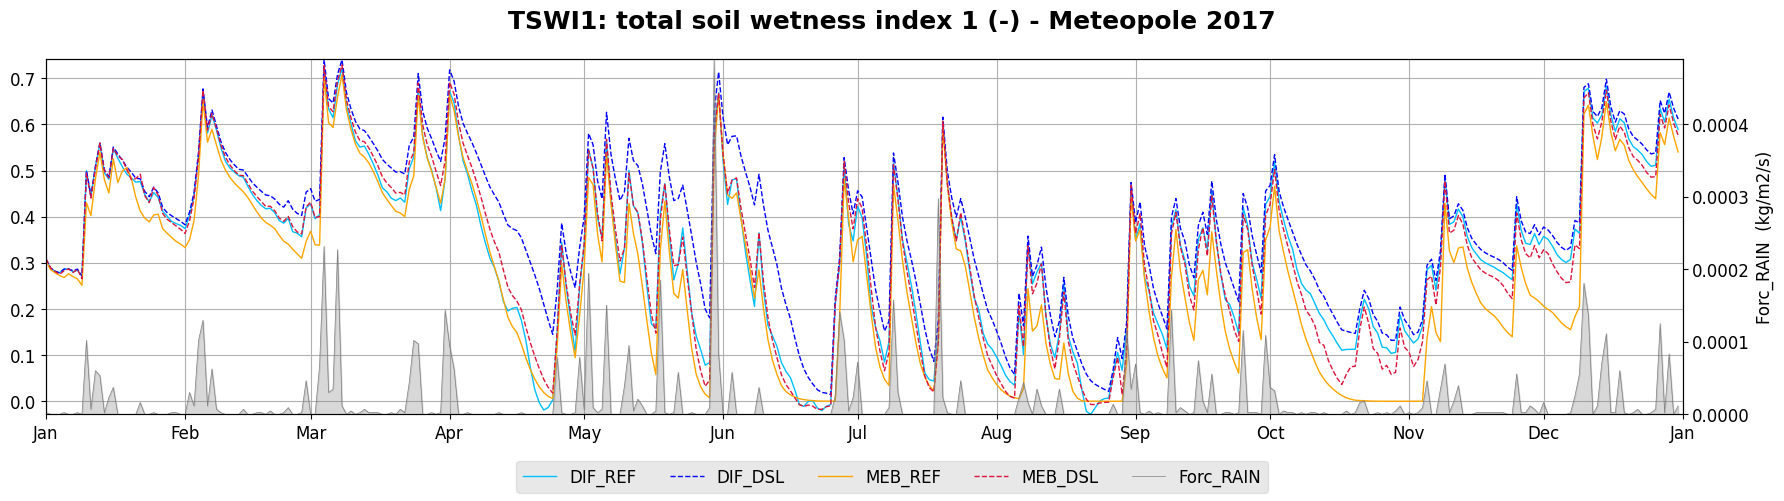

In [72]:
campo = 0 # posición en field_vars lo voy a hacer para que por ahora salga de uno en uno (H=4)
add_forc = True # añadir o no un forzamiento
forzamiento = 3 # se podría hacer para otro forzamiento más pero no lo recomiendo, porque sería tener 3 ejes y en una misma gráfica (Forc_RAIN=3)
experiments = [0,1, 2, 3] #[0, 1, 2, 3] # Posiciones. Por si no quiero representarlos todos
# exps = ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

month_interv = [1, 12] # Intervalo de meses (Enero = 1). Ambos inclusive
# day_interv = [1, 15] # ESTÁ PENDIENTE, hacer para dentro de un solo mes supongo? por ahora

observation = False # Para ver o no las observaciones de H y LE
corrected = False # Para ver las observaciones con o sin corrección (ojo, no tengo los correctad en horario)

graph_type = 'diario'
# graph_type = '30min'
# graph_type = 'horario'
# graph_type = 'promedio mensual'
# graph_type = 'boxplot mensual'
# graph_type = 'diario acumulado'
# graph_type = 'energia'


########## Ahora ya la figura, esto no se debería necesitar editar:
meses = [calendar.month_abbr[i] for i in range(1, 13)] + ['Jan']
dias_por_mes = [calendar.monthrange(2017, i)[1] for i in range(1, 13)] 
dias_por_mes.insert(0, 0)

if graph_type == 'diario':
  posiciones_meses = np.cumsum(dias_por_mes)
  y1 = MPOLE_daily
  y2 = MPOLE_MOD_daily
  y3 = MPOLE_closing_daily
elif graph_type == 'horario':
  posiciones_meses = np.cumsum(dias_por_mes)*24
  y1 = MPOLE_hours
  y2 = MPOLE_MOD_hours
elif graph_type == '30min':
  posiciones_meses = np.cumsum(dias_por_mes)*48
  y1 = MPOLE
  y2 = MPOLE_MOD
  y3 = MPOLE_closing_reindexed
elif graph_type == 'promedio mensual':
  cycle = [24] * 12
  cycle.insert(0, 0)
  posiciones_meses = np.cumsum(cycle)
  y1 = MPOLE_mcycle
  y2 = MPOLE_MOD_mcycle
  y3 = MPOLE_closing_mcycle
elif graph_type == 'diario acumulado':
  posiciones_meses = np.cumsum(dias_por_mes)
  y1 = MPOLE_daily_sum
  y2 = MPOLE_MOD_daily_sum
  y3 = MPOLE_closing_daily_sum
elif graph_type == 'energia':
  posiciones_meses = np.cumsum(dias_por_mes)
  y1 = MPOLE_energy
  y2 = MPOLE_MOD_energy
  y3 = MPOLE_closing_energy
elif graph_type == 'boxplot mensual':
  if observation == True:
    cycle = [24] * 12
    cycle.insert(0, 0)
    posiciones_meses = np.cumsum(cycle)
    posiciones_meses2 = np.cumsum(cycle)[1:]-12
  else:
    posiciones_meses = np.cumsum(dias_por_mes)
    posiciones_meses2 = np.cumsum(dias_por_mes)[1:]-15
  y1 = MPOLE_mcycle
  y2 = MPOLE_MOD_mcycle
  y3 = MPOLE_closing_mcycle
  y4 = [grupo[field_vars[campo]+'_'+exps[experiments[0]]].tolist() for _, grupo in MPOLE_hours.groupby(level=0)] # MPOLE_daily

fig, ax1 = plt.subplots(figsize=(18,5))

minimos, maximos = [], []

if graph_type == 'boxplot mensual':
  bp=ax1.boxplot(y4, positions=posiciones_meses2, widths=6, patch_artist = True, boxprops = dict(facecolor = colors[experiments[0]]))
  fig.legend([bp["boxes"][0]], [exps[experiments[0]]], facecolor='lightgray',framealpha=0.5, bbox_to_anchor=(0.4, 0.1))
else:
  # minimos, maximos = [], []
  for exp in experiments:
    ax1.plot(y1[field_vars[campo]+'_'+exps[exp]].values, label=exps[exp], color=colors[exp], linestyle=styles[exp], linewidth=1)
    minimos.append(np.min(y1[field_vars[campo]+'_'+exps[exp]].values))
    maximos.append(np.max(y1[field_vars[campo]+'_'+exps[exp]].values))
ax1.grid(True)


if add_forc == True:
  ax2 = ax1.twinx()
  if graph_type == 'energia':
    ax2.set_ylabel(forcing_vars[forzamiento]+'  ('+forcing_units_2[forzamiento]+')')
  else:
    ax2.set_ylabel(forcing_vars[forzamiento]+'  ('+forcing_units[forzamiento]+')')
  ax2.plot(y2[forcing_vars[forzamiento]].values, color=colors[6], label=forcing_vars[forzamiento], linewidth=0.5)
  ax2.fill_between(np.arange(0,len(y2)),y2[forcing_vars[forzamiento]].values, color=colors[6], alpha=0.3)
  ax2.set_ylim([np.min(y2[forcing_vars[forzamiento]].values), np.max(y2[forcing_vars[forzamiento]].values)])

# minimos, maximos = [], []
if observation == True and field_vars[campo] in my_dict:
  ax1.plot(y1[my_dict[field_vars[campo]]].values,label='obs',color=colors[4],linestyle=styles[4],linewidth=1)
  minimos.append(np.min(y1[my_dict[field_vars[campo]]].values))
  maximos.append(np.max(y1[my_dict[field_vars[campo]]].values))
if corrected == True and graph_type != 'horario':
  # gg = y3[field_vars[campo]+'_corrected'].interpolate()
  # ax1.plot(gg.values,label='obs_cor',color=colors[5],linestyle=styles[5],linewidth=1)
  ax1.plot(y3[field_vars[campo]+'_corrected'].values,label='obs_cor',color=colors[5],linestyle=styles[5],linewidth=1)
  minimos.append(np.min(y3[field_vars[campo]+'_corrected'].dropna().values))
  maximos.append(np.max(y3[field_vars[campo]+'_corrected'].dropna().values))

# Estas 4 líneas las he añadido al incluir el 30min:
minimos = np.array(minimos)
maximos = np.array(maximos)
minimos = minimos[np.isfinite(minimos)]
maximos = maximos[np.isfinite(maximos)]

ax1.set_ylim([np.min(minimos), np.max(maximos)])

fig.legend(facecolor='lightgray',framealpha=0.5, ncol=7, loc='lower center')
if graph_type == 'energia':
  fig.suptitle(field_vars[campo]+': '+field_names[campo]+' ('+field_units_2[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')
else:
  fig.suptitle(field_vars[campo]+': '+field_names[campo]+' ('+field_units[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(bottom=0.17)

plt.xticks(posiciones_meses, meses)

if graph_type == 'horario':
  plt.xticks(np.arange(0,365)*24)
if graph_type == '30min':
  plt.xticks(np.arange(0,365)*48)

plt.xlim([posiciones_meses[month_interv[0] - 1], posiciones_meses[month_interv[1]]]) # Esto para sacar meses concretos

plt.show()
plt.close()

# ESTA ES LA QUE SE PUEDE EDITAR:

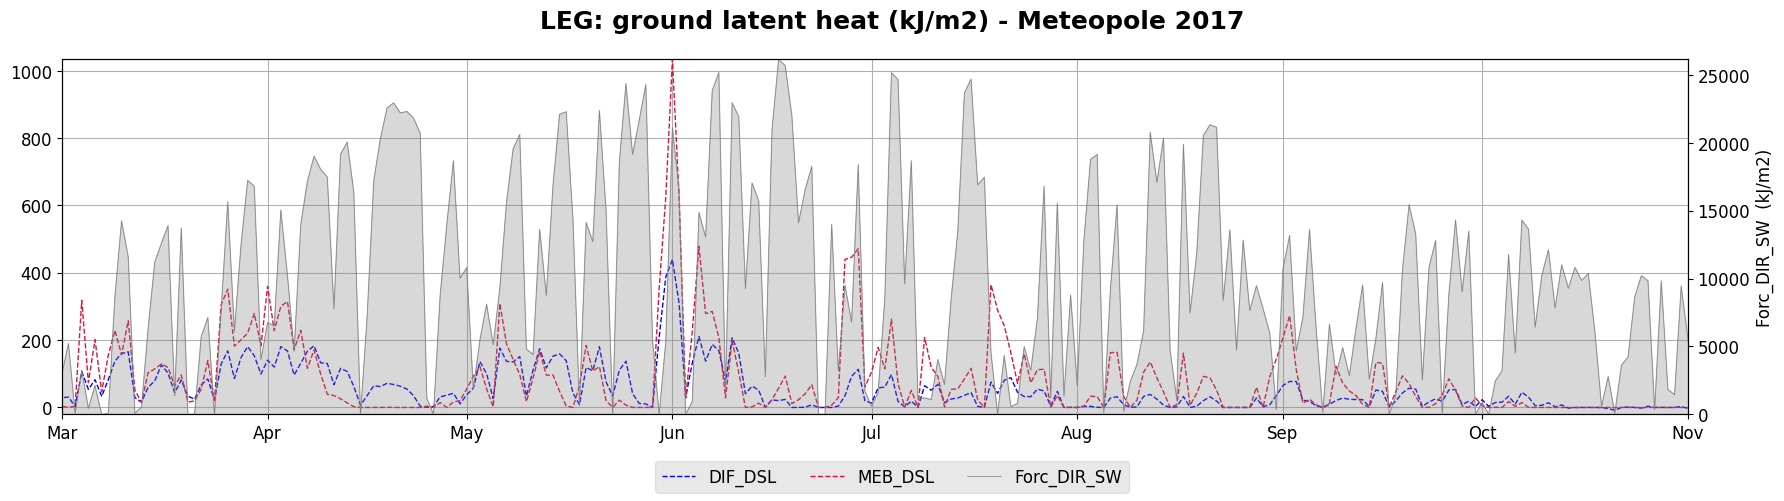

In [87]:
campo = 7 # posición en field_vars lo voy a hacer para que por ahora salga de uno en uno (H=4)
add_forc = True # añadir o no un forzamiento
forzamiento = 6 # se podría hacer para otro forzamiento más pero no lo recomiendo, porque sería tener 3 ejes y en una misma gráfica (Forc_RAIN=3)
experiments = [1, 3] #[0, 1, 2, 3] # Posiciones. Por si no quiero representarlos todos
# exps = ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

month_interv = [3, 10] # Intervalo de meses (Enero = 1). Ambos inclusive
# day_interv = [1, 15] # ESTÁ PENDIENTE, hacer para dentro de un solo mes supongo? por ahora

observation = False # Para ver o no las observaciones de H y LE
corrected = False # Para ver las observaciones con o sin corrección (ojo, no tengo los correctad en horario)

# graph_type = 'diario'
# graph_type = '30min'
# graph_type = 'horario'
# graph_type = 'promedio mensual'
# graph_type = 'boxplot mensual'
# graph_type = 'diario acumulado'
graph_type = 'energia'


########## Ahora ya la figura, esto no se debería necesitar editar:
meses = [calendar.month_abbr[i] for i in range(1, 13)] + ['Jan']
dias_por_mes = [calendar.monthrange(2017, i)[1] for i in range(1, 13)] 
dias_por_mes.insert(0, 0)

if graph_type == 'diario':
  posiciones_meses = np.cumsum(dias_por_mes)
  y1 = MPOLE_daily
  y2 = MPOLE_MOD_daily
  y3 = MPOLE_closing_daily
elif graph_type == 'horario':
  posiciones_meses = np.cumsum(dias_por_mes)*24
  y1 = MPOLE_hours
  y2 = MPOLE_MOD_hours
elif graph_type == '30min':
  posiciones_meses = np.cumsum(dias_por_mes)*48
  y1 = MPOLE
  y2 = MPOLE_MOD
  y3 = MPOLE_closing_reindexed
elif graph_type == 'promedio mensual':
  cycle = [24] * 12
  cycle.insert(0, 0)
  posiciones_meses = np.cumsum(cycle)
  y1 = MPOLE_mcycle
  y2 = MPOLE_MOD_mcycle
  y3 = MPOLE_closing_mcycle
elif graph_type == 'diario acumulado':
  posiciones_meses = np.cumsum(dias_por_mes)
  y1 = MPOLE_daily_sum
  y2 = MPOLE_MOD_daily_sum
  y3 = MPOLE_closing_daily_sum
elif graph_type == 'energia':
  posiciones_meses = np.cumsum(dias_por_mes)
  y1 = MPOLE_energy
  y2 = MPOLE_MOD_energy
  y3 = MPOLE_closing_energy
elif graph_type == 'boxplot mensual':
  if observation == True:
    cycle = [24] * 12
    cycle.insert(0, 0)
    posiciones_meses = np.cumsum(cycle)
    posiciones_meses2 = np.cumsum(cycle)[1:]-12
  else:
    posiciones_meses = np.cumsum(dias_por_mes)
    posiciones_meses2 = np.cumsum(dias_por_mes)[1:]-15
  y1 = MPOLE_mcycle
  y2 = MPOLE_MOD_mcycle
  y3 = MPOLE_closing_mcycle
  y4 = [grupo[field_vars[campo]+'_'+exps[experiments[0]]].tolist() for _, grupo in MPOLE_hours.groupby(level=0)] # MPOLE_daily

fig, ax1 = plt.subplots(figsize=(18,5))

minimos, maximos = [], []

if graph_type == 'boxplot mensual':
  bp=ax1.boxplot(y4, positions=posiciones_meses2, widths=6, patch_artist = True, boxprops = dict(facecolor = colors[experiments[0]]))
  fig.legend([bp["boxes"][0]], [exps[experiments[0]]], facecolor='lightgray',framealpha=0.5, bbox_to_anchor=(0.4, 0.1))
else:
  # minimos, maximos = [], []
  for exp in experiments:
    ax1.plot(y1[field_vars[campo]+'_'+exps[exp]].values, label=exps[exp], color=colors[exp], linestyle=styles[exp], linewidth=1)
    minimos.append(np.min(y1[field_vars[campo]+'_'+exps[exp]].values))
    maximos.append(np.max(y1[field_vars[campo]+'_'+exps[exp]].values))
ax1.grid(True)


if add_forc == True:
  ax2 = ax1.twinx()
  if graph_type == 'energia':
    ax2.set_ylabel(forcing_vars[forzamiento]+'  ('+forcing_units_2[forzamiento]+')')
  else:
    ax2.set_ylabel(forcing_vars[forzamiento]+'  ('+forcing_units[forzamiento]+')')
  ax2.plot(y2[forcing_vars[forzamiento]].values, color=colors[6], label=forcing_vars[forzamiento], linewidth=0.5)
  ax2.fill_between(np.arange(0,len(y2)),y2[forcing_vars[forzamiento]].values, color=colors[6], alpha=0.3)
  ax2.set_ylim([np.min(y2[forcing_vars[forzamiento]].values), np.max(y2[forcing_vars[forzamiento]].values)])

# minimos, maximos = [], []
if observation == True and field_vars[campo] in my_dict:
  ax1.plot(y1[my_dict[field_vars[campo]]].values,label='obs',color=colors[4],linestyle=styles[4],linewidth=1)
  minimos.append(np.min(y1[my_dict[field_vars[campo]]].values))
  maximos.append(np.max(y1[my_dict[field_vars[campo]]].values))
if corrected == True and graph_type != 'horario':
  # gg = y3[field_vars[campo]+'_corrected'].interpolate()
  # ax1.plot(gg.values,label='obs_cor',color=colors[5],linestyle=styles[5],linewidth=1)
  ax1.plot(y3[field_vars[campo]+'_corrected'].values,label='obs_cor',color=colors[5],linestyle=styles[5],linewidth=1)
  minimos.append(np.min(y3[field_vars[campo]+'_corrected'].dropna().values))
  maximos.append(np.max(y3[field_vars[campo]+'_corrected'].dropna().values))

# Estas 4 líneas las he añadido al incluir el 30min:
minimos = np.array(minimos)
maximos = np.array(maximos)
minimos = minimos[np.isfinite(minimos)]
maximos = maximos[np.isfinite(maximos)]

ax1.set_ylim([np.min(minimos), np.max(maximos)])

fig.legend(facecolor='lightgray',framealpha=0.5, ncol=7, loc='lower center')
if graph_type == 'energia':
  fig.suptitle(field_vars[campo]+': ground latent heat ('+field_units_2[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')
else:
  fig.suptitle(field_vars[campo]+': '+field_names[campo]+' ('+field_units[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(bottom=0.17)

plt.xticks(posiciones_meses, meses)

if graph_type == 'horario':
  plt.xticks(np.arange(0,365)*24)
if graph_type == '30min':
  plt.xticks(np.arange(0,365)*48)

plt.xlim([posiciones_meses[month_interv[0] - 1], posiciones_meses[month_interv[1]]]) # Esto para sacar meses concretos

plt.show()
plt.close()

# PROYECTO "REGPLOTS":
### Con una sola celda sacar todas las posibilidades que quiera cómodamente de gráficas REGPLOT MENSUALES, de los parámetros que quiera, con obs u obs_cor, para el experimento que quiera, y pudiendo escoger si quiero representar solo los valores positivos de las simulaciones (¿u observaciones?).

Hago lo mismo de antes pero solo para H y eliminando los valores negativos (por la noche). Las figuras se guardan como 'Meteopole_H_OBSvs[exp]_day.png'.

[Ojo, no se llama closure rate a los scatter plots, eso es otra cosa. Les podemos llamar Scatterplots mismamente. Y al representarlos usar todos los puntos del mes (datos diarios?) no el promedio de cada hora.]

[Por tanto, hacer los scatter plots pero filtrando solo los datos que ocurren durante el día (solo los valores positivos). Esto en el caso de H. No haría falta para LE.]

Hecho está, ahora tengo que entenderlo, interpretarlo y saber sacarle sentido o concluir que no era buena idea.

In [23]:
# campo = 5 # posición en field_vars (H=4, LE=5)
# exp = 0 # Posición del experimento ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

# corrected = True # Para ver las observaciones con o sin corrección (ojo, no tengo los correctad en horario)

# # graph_type = 'promedio mensual'
# # graph_type = 'diario'
# graph_type = 'diario positivos'

# ########## Ahora ya la figura, esto no se debería necesitar editar:
# fig = plt.figure(figsize=(18,15))
# axes = fig.subplots(nrows=4, ncols=3)

# for i in [0,1,2,3]:
#   for j in [0,1,2]:
#       if graph_type == 'promedio mensual':
#         y=MPOLE_mcycle[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values
#         if corrected == True:
#           x=MPOLE_closing_mcycle[field_vars[campo]+'_corrected'].loc[3*i+j+1].values
#         else:
#           x=MPOLE_mcycle[field_vars[campo]].loc[3*i+j+1].values
#       elif graph_type == 'diario':
#         y=MPOLE_daily[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values
#         if corrected == True:
#           x=MPOLE_closing_daily[field_vars[campo]+'_corrected'].loc[3*i+j+1].values
#         else:
#           x=MPOLE_daily[field_vars[campo]].loc[3*i+j+1].values
#       elif graph_type == 'diario positivos':
#         MPOLE_daily_filt = MPOLE_daily.loc[MPOLE_daily[field_vars[campo]+'_'+exps[exp]] >= 0]
#         indices_a_eliminar = MPOLE_daily.index.difference(MPOLE_daily_filt.index)
#         y=MPOLE_daily_filt[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values
#         if corrected == True:
#           MPOLE_closing_daily_filt = MPOLE_closing_daily.drop(indices_a_eliminar)
#           x=MPOLE_closing_daily_filt[field_vars[campo]+'_corrected'].loc[3*i+j+1].values
#         else:
#           x=MPOLE_daily_filt[field_vars[campo]].loc[3*i+j+1].values

#         if corrected == True:
#           xlabel = 'obs_cor'
#         else:
#           xlabel = 'obs'

#       slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x,y)
#       sns.regplot(x=x, y=y, ax=axes[i,j],
#                  scatter_kws={"color":colors[exp],"edgecolor":"black","alpha":1,"s":10},
#                  line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope1,intercept1), "ls":"--", "color":colors[exp]})
#       axes[i,j].legend()
#       axes[i,j].set_title(calendar.month_name[3*i+j+1])
#       if j == 0:
#         axes[i,j].set_ylabel(exps[exp])
#       if i == 3:
#         axes[i,j].set_xlabel(xlabel)
# lines, labels = fig.axes[-1].get_legend_handles_labels()

# fig.suptitle('Regplot '+field_vars[campo]+' & '+xlabel+' - Meteopole 2017', fontsize=18, fontweight='bold')
# fig.tight_layout()
# fig.subplots_adjust(bottom=0.06)
# plt.show()
# plt.close()

# PROYECTO "GRÁFICAS MENSUALES":
### Con una sola celda sacar todas las posibilidades que quiera cómodamente de gráficas MENSUALES, de los parámetros que quiera, con obs U obs_cor o ambas, para los experimentos que quiera, y ya sea con datos diarios, horarios o promedios mensuales horarios.

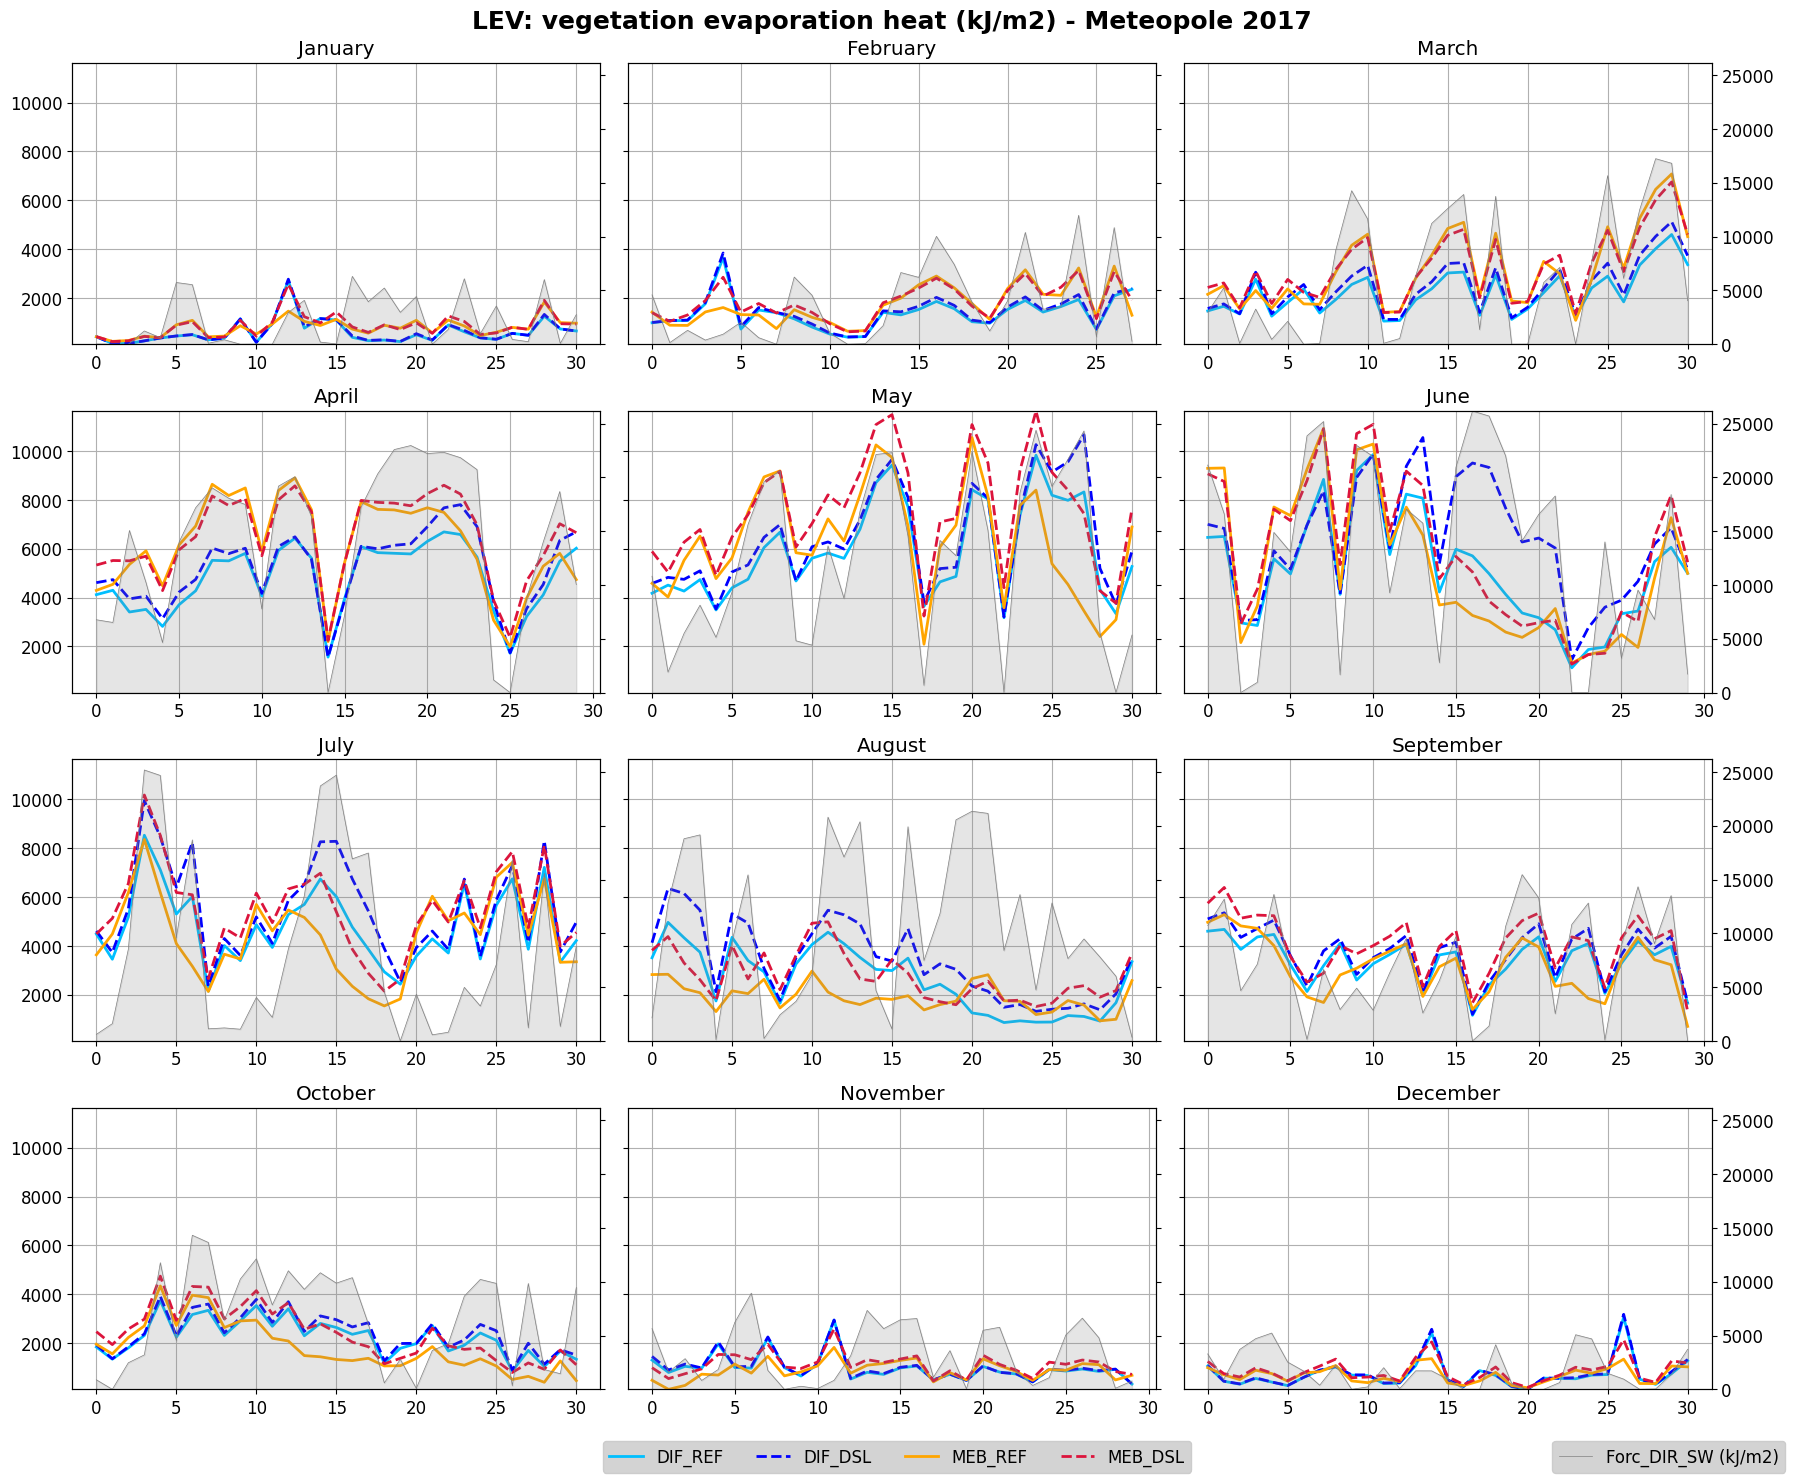

In [77]:
campo = 6 # posición en field_vars lo voy a hacer para que por ahora salga de uno en uno (H=4)
add_forc = True # añadir o no un forzamiento, por ahora no interesa mucho quizás, porque es mejor verlo en las series temporales
forzamiento = 6 # se podría hacer para otro forzamiento más pero no lo recomiendo, porque sería tener 3 ejes y en una misma gráfica (Forc_RAIN=3)
experiments = [0, 1, 2, 3] # Posiciones. ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

matplotlib.rcParams['lines.linewidth'] = 2

observation = True # Para ver o no las observaciones de H y LE
corrected = True # Para ver las observaciones con o sin corrección (ojo, no tengo los correctad en horario)
rescalado = True # en principio siempre lo vamos a querer True

# graph_type = 'diario'
# graph_type = 'horario' # no se ve nada
# graph_type = 'promedio mensual'
# graph_type = 'diario acumulado'
graph_type = 'energia'


########## Ahora ya la figura, esto no se debería necesitar editar:
fig = plt.figure(figsize=(18,15))
axes = fig.subplots(nrows=4, ncols=3)
minimos, maximos = [], []

if graph_type == 'diario':
  y1 = MPOLE_daily
  y2 = MPOLE_MOD_daily
  y3 = MPOLE_closing_daily
if graph_type == 'horario':
  y1 = MPOLE_hours
  y2 = MPOLE_MOD_hours
if graph_type == 'promedio mensual':
  y1 = MPOLE_mcycle
  y2 = MPOLE_MOD_mcycle
  y3 = MPOLE_closing_mcycle
if graph_type == 'diario acumulado':
  y1 = MPOLE_daily_sum
  y2 = MPOLE_MOD_daily_sum
  y3 = MPOLE_closing_daily_sum
elif graph_type == 'energia':
  y1 = MPOLE_energy
  y2 = MPOLE_MOD_energy
  y3 = MPOLE_closing_energy

for i in [0,1,2,3]:
  for j in [0,1,2]:
    for exp in experiments:
      axes[i,j].plot(y1[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values,label=exps[exp],color=colors[exp],linestyle=styles[exp])
      minimos.append(np.min(y1[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values))
      maximos.append(np.max(y1[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values))

    if j != 0:
      axes[i,j].set_yticklabels([])
    
    axes[i,j].set_title(calendar.month_name[3*i+j+1])
    axes[i,j].grid(True)

    if add_forc == True:
      ax2 = axes[i,j].twinx()
      if graph_type == 'energia':
        ax2.plot(y2[forcing_vars[forzamiento]].loc[3*i+j+1].values, color=colors[6], label=forcing_vars[forzamiento]+' ('+forcing_units_2[forzamiento]+')', linewidth=0.5)
      else:
        ax2.plot(y2[forcing_vars[forzamiento]].loc[3*i+j+1].values, color=colors[6], label=forcing_vars[forzamiento]+' ('+forcing_units[forzamiento]+')', linewidth=0.5)
      ax2.fill_between(np.arange(0,len(y2[forcing_vars[forzamiento]].loc[3*i+j+1].values)),y2[forcing_vars[forzamiento]].loc[3*i+j+1].values, color=colors[6], alpha=0.2)
      ax2.set_ylim([np.min(y2[forcing_vars[forzamiento]].values), np.max(y2[forcing_vars[forzamiento]].values)]) ### a ver si me convence
      if j != 2:
        ax2.set_yticklabels([])

    if observation == True and field_vars[campo] in my_dict:
      axes[i,j].plot(y1[my_dict[field_vars[campo]]].loc[3*i+j+1].values,label='obs',color=colors[4],linestyle=styles[4])
      maximos.append(np.max(y1[my_dict[field_vars[campo]]].loc[3*i+j+1].values))
      minimos.append(np.min(y1[my_dict[field_vars[campo]]].loc[3*i+j+1].values))
      if field_vars[campo] in ('H', 'LE') and corrected == True and graph_type != 'horario':
        axes[i,j].plot(y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values,label='obs_cor',color=colors[5],linestyle=styles[5])
        maximos.append(np.max(y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values))
        minimos.append(np.min(y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values))
        axes[i,j].fill_between(range(0,len(y1[my_dict[field_vars[campo]]].loc[3*i+j+1].values)),y1[field_vars[campo]].loc[3*i+j+1].values, y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values, color='gray', alpha=0.15)




# y1[field_vars[campo]].loc[3*i+j+1].values,
if rescalado == True:
  for i in [0,1,2,3]:
    for j in [0,1,2]:
      axes[i,j].set_ylim([np.min(minimos), np.max(maximos)])

lines, labels = fig.axes[1].get_legend_handles_labels()
fig.legend(lines, labels, facecolor='lightgray', loc='lower center',framealpha=1, ncol=6)
if graph_type == 'energia':
  fig.suptitle(field_vars[campo]+': '+field_names[campo]+' ('+field_units_2[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')
else:
  fig.suptitle(field_vars[campo]+': '+field_names[campo]+' ('+field_units[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')

if add_forc == True:
  lines, labels = fig.axes[-1].get_legend_handles_labels()
  fig.legend(lines, labels, facecolor='lightgray', loc='lower right',framealpha=1, ncol=1)

fig.tight_layout()
fig.subplots_adjust(bottom=0.06)
#  fig.savefig(figs_path+station_name+'_months.png',facecolor='white')
plt.show()
plt.close()

# ESTA ES LA QUE SE PUEDE EDITAR:

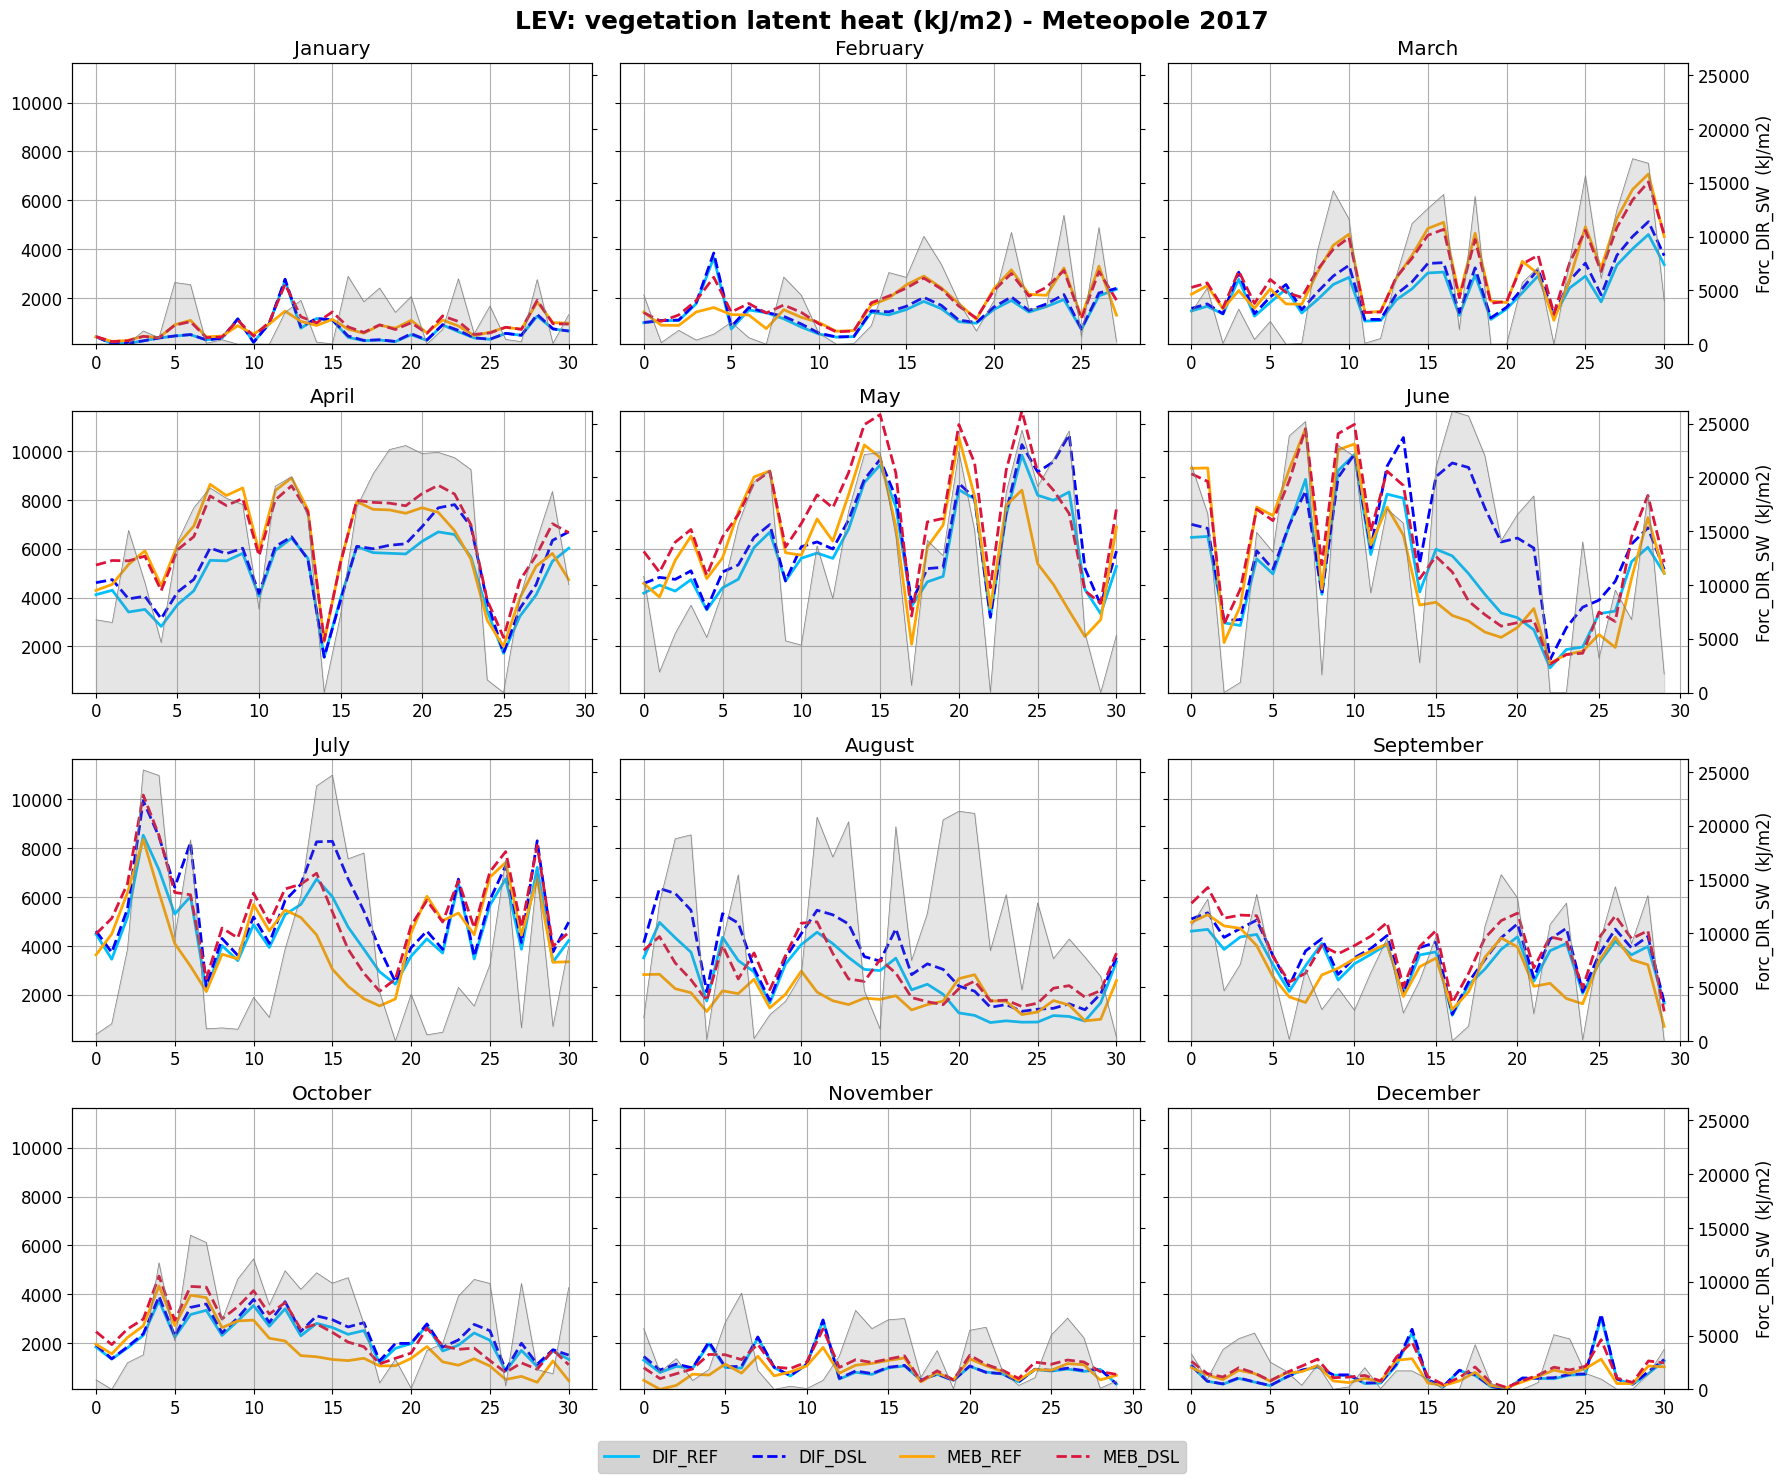

In [81]:
campo = 6 # posición en field_vars lo voy a hacer para que por ahora salga de uno en uno (H=4)
add_forc = True # añadir o no un forzamiento, por ahora no interesa mucho quizás, porque es mejor verlo en las series temporales
forzamiento = 6 # se podría hacer para otro forzamiento más pero no lo recomiendo, porque sería tener 3 ejes y en una misma gráfica (Forc_RAIN=3)
experiments = [0, 1, 2, 3] # Posiciones. ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

matplotlib.rcParams['lines.linewidth'] = 2

observation = True # Para ver o no las observaciones de H y LE
corrected = True # Para ver las observaciones con o sin corrección (ojo, no tengo los correctad en horario)
rescalado = True # en principio siempre lo vamos a querer True

# graph_type = 'diario'
# graph_type = 'horario' # no se ve nada
# graph_type = 'promedio mensual'
# graph_type = 'diario acumulado'
graph_type = 'energia'


########## Ahora ya la figura, esto no se debería necesitar editar:
fig = plt.figure(figsize=(18,15))
axes = fig.subplots(nrows=4, ncols=3)
minimos, maximos = [], []

if graph_type == 'diario':
  y1 = MPOLE_daily
  y2 = MPOLE_MOD_daily
  y3 = MPOLE_closing_daily
if graph_type == 'horario':
  y1 = MPOLE_hours
  y2 = MPOLE_MOD_hours
if graph_type == 'promedio mensual':
  y1 = MPOLE_mcycle
  y2 = MPOLE_MOD_mcycle
  y3 = MPOLE_closing_mcycle
if graph_type == 'diario acumulado':
  y1 = MPOLE_daily_sum
  y2 = MPOLE_MOD_daily_sum
  y3 = MPOLE_closing_daily_sum
elif graph_type == 'energia':
  y1 = MPOLE_energy
  y2 = MPOLE_MOD_energy
  y3 = MPOLE_closing_energy

for i in [0,1,2,3]:
  for j in [0,1,2]:
    for exp in experiments:
      axes[i,j].plot(y1[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values,label=exps[exp],color=colors[exp],linestyle=styles[exp])
      minimos.append(np.min(y1[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values))
      maximos.append(np.max(y1[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values))

    if j != 0:
      axes[i,j].set_yticklabels([])
    
    axes[i,j].set_title(calendar.month_name[3*i+j+1])
    axes[i,j].grid(True)

    if add_forc == True:
      ax2 = axes[i,j].twinx()
      if graph_type == 'energia':
        # ax2.set_ylabel(forcing_vars[forzamiento]+'  ('+forcing_units_2[forzamiento]+')')
        ax2.plot(y2[forcing_vars[forzamiento]].loc[3*i+j+1].values, color=colors[6], label=forcing_vars[forzamiento]+' ('+forcing_units_2[forzamiento]+')', linewidth=0.5)
      else:
        ax2.plot(y2[forcing_vars[forzamiento]].loc[3*i+j+1].values, color=colors[6], label=forcing_vars[forzamiento]+' ('+forcing_units[forzamiento]+')', linewidth=0.5)
      ax2.fill_between(np.arange(0,len(y2[forcing_vars[forzamiento]].loc[3*i+j+1].values)),y2[forcing_vars[forzamiento]].loc[3*i+j+1].values, color=colors[6], alpha=0.2)
      ax2.set_ylim([np.min(y2[forcing_vars[forzamiento]].values), np.max(y2[forcing_vars[forzamiento]].values)]) ### a ver si me convence
      if j != 2:
        ax2.set_yticklabels([])
      if j == 2:
        ax2.set_ylabel(forcing_vars[forzamiento]+'  ('+forcing_units_2[forzamiento]+')')

    if observation == True and field_vars[campo] in my_dict:
      axes[i,j].plot(y1[my_dict[field_vars[campo]]].loc[3*i+j+1].values,label='obs',color=colors[4],linestyle=styles[4])
      maximos.append(np.max(y1[my_dict[field_vars[campo]]].loc[3*i+j+1].values))
      minimos.append(np.min(y1[my_dict[field_vars[campo]]].loc[3*i+j+1].values))
      if field_vars[campo] in ('H', 'LE') and corrected == True and graph_type != 'horario':
        axes[i,j].plot(y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values,label='obs_cor',color=colors[5],linestyle=styles[5])
        maximos.append(np.max(y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values))
        minimos.append(np.min(y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values))
        axes[i,j].fill_between(range(0,len(y1[my_dict[field_vars[campo]]].loc[3*i+j+1].values)),y1[field_vars[campo]].loc[3*i+j+1].values, y3[field_vars[campo]+'_corrected'].loc[3*i+j+1].values, color='gray', alpha=0.15)




# y1[field_vars[campo]].loc[3*i+j+1].values,
if rescalado == True:
  for i in [0,1,2,3]:
    for j in [0,1,2]:
      axes[i,j].set_ylim([np.min(minimos), np.max(maximos)])

lines, labels = fig.axes[1].get_legend_handles_labels()
fig.legend(lines, labels, facecolor='lightgray', loc='lower center',framealpha=1, ncol=6)
if graph_type == 'energia':
  fig.suptitle(field_vars[campo]+': vegetation latent heat ('+field_units_2[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')
else:
  fig.suptitle(field_vars[campo]+': '+field_names[campo]+' ('+field_units[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')

# if add_forc == True:
#   lines, labels = fig.axes[-1].get_legend_handles_labels()
#   fig.legend(lines, labels, facecolor='lightgray', loc='lower right',framealpha=1, ncol=1)

fig.tight_layout()
fig.subplots_adjust(bottom=0.06)
#  fig.savefig(figs_path+station_name+'_months.png',facecolor='white')
plt.show()
plt.close()

# PROYECTO "SCATTERPLOTS":
### Con una sola celda sacar todas las posibilidades que quiera cómodamente de gráficas SCATTERPLOT MENSUALES, de los parámetros que quiera, con obs u obs_cor, para el experimento que quiera, y pudiendo escoger si quiero representar solo los valores positivos de las simulaciones (¿u observaciones?).

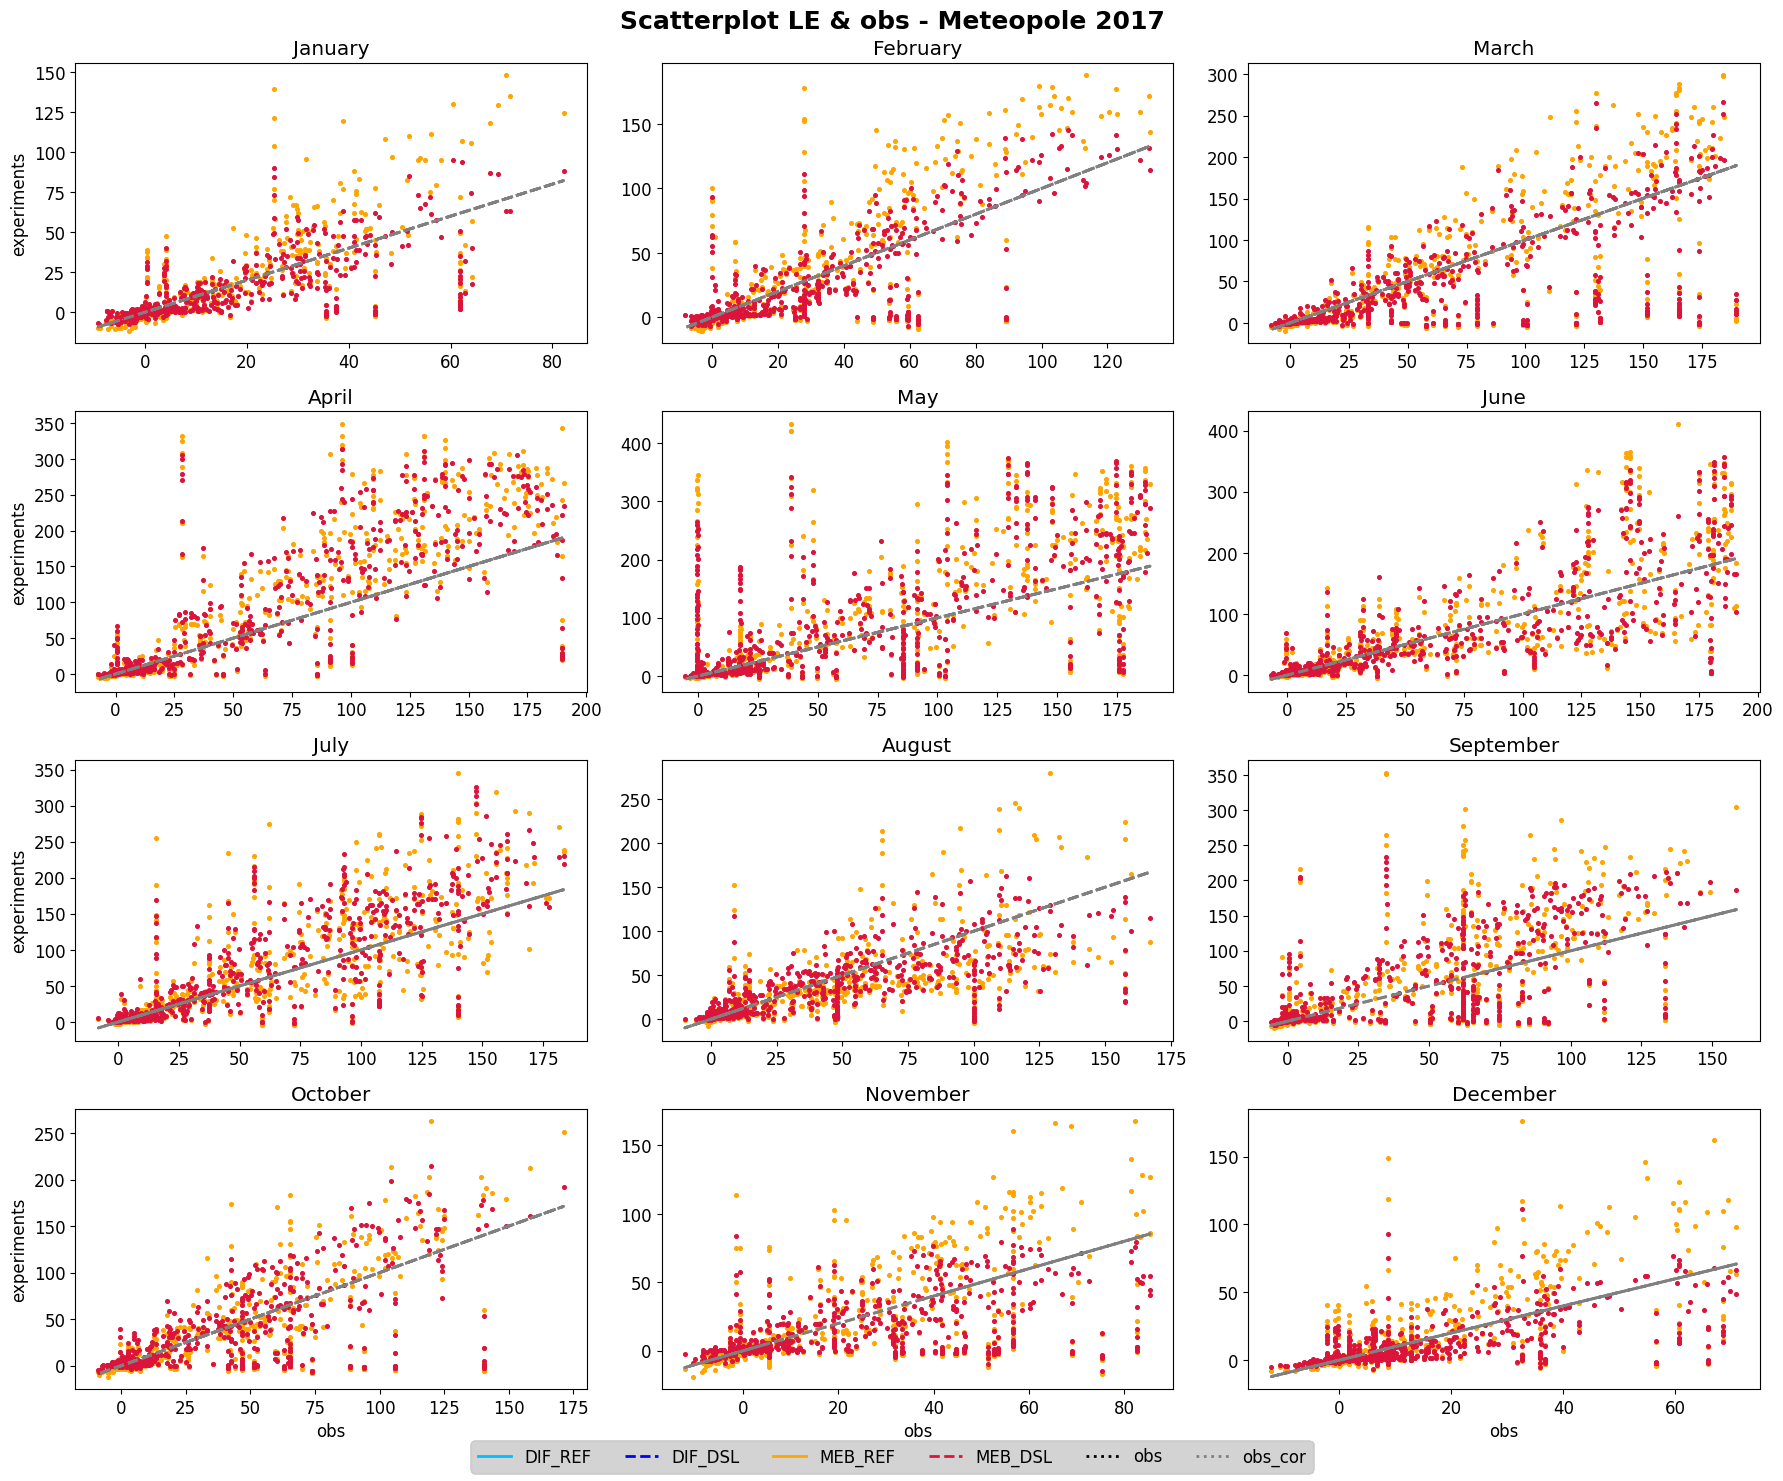

In [25]:
campo = 5 # posición en field_vars (H=4, LE=5)
experiments = [2,3] #[0,1,2,3] # Posición del experimento ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

corrected = False # Para ver las observaciones con o sin corrección (ojo, no tengo los correctad en horario)

# graph_type = 'promedio mensual'
# graph_type = 'diario'
graph_type = 'horario'
# graph_type = 'diario positivos'

########## Ahora ya la figura, esto no se debería necesitar editar:
fig = plt.figure(figsize=(18,15))
axes = fig.subplots(nrows=4, ncols=3)

for exp in experiments:
  for i in [0,1,2,3]:
    for j in [0,1,2]:
        if graph_type == 'promedio mensual':
          y=MPOLE_mcycle[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values
          if corrected == True:
            x=MPOLE_closing_mcycle[field_vars[campo]+'_corrected'].loc[3*i+j+1].values
          else:
            x=MPOLE_mcycle[field_vars[campo]].loc[3*i+j+1].values
        elif graph_type == 'diario':
          y=MPOLE_daily[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values
          if corrected == True:
            x=MPOLE_closing_daily[field_vars[campo]+'_corrected'].loc[3*i+j+1].values
          else:
            x=MPOLE_daily[field_vars[campo]].loc[3*i+j+1].values
        elif graph_type == 'horario':
          y=MPOLE_hours[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values
          if corrected == True:
            common_index = MPOLE_hours.index.intersection(MPOLE_closing_hours.index)
            df1_filtered = MPOLE_hours.loc[common_index]
            df2_filtered = MPOLE_closing_hours.loc[common_index]
            x=df2_filtered[field_vars[campo]+'_corrected'].loc[3*i+j+1].values
            y=df1_filtered[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values
          else:
            x=MPOLE_hours[field_vars[campo]].loc[3*i+j+1].values
        elif graph_type == 'diario positivos':
          MPOLE_daily_filt = MPOLE_daily.loc[MPOLE_daily[field_vars[campo]+'_'+exps[exp]] >= 0]
          indices_a_eliminar = MPOLE_daily.index.difference(MPOLE_daily_filt.index)
          y=MPOLE_daily_filt[field_vars[campo]+'_'+exps[exp]].loc[3*i+j+1].values
          if corrected == True:
            MPOLE_closing_daily_filt = MPOLE_closing_daily.drop(indices_a_eliminar)
            x=MPOLE_closing_daily_filt[field_vars[campo]+'_corrected'].loc[3*i+j+1].values
          else:
            x=MPOLE_daily_filt[field_vars[campo]].loc[3*i+j+1].values

        if corrected == True:
          xlabel = 'obs_cor'
        else:
          xlabel = 'obs'

        axes[i,j].scatter(x,y,color=colors[exp], s=7, label=exps[exp])
        axes[i,j].plot(x,x, color='grey', ls='--')
      
        axes[i,j].set_title(calendar.month_name[3*i+j+1])
        if j == 0:
          axes[i,j].set_ylabel(exps[exp])
          if len(experiments) > 1:
            axes[i,j].set_ylabel('experiments')
            fig.legend(lines, labels, facecolor='lightgray', loc='lower center',framealpha=1, ncol=6)
        if i == 3:
          axes[i,j].set_xlabel(xlabel)
lines, labels = fig.axes[-1].get_legend_handles_labels()

fig.suptitle('Scatterplot '+field_vars[campo]+' & '+xlabel+' - Meteopole 2017', fontsize=18, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(bottom=0.06)
plt.show()
plt.close()

# PROYECTO "SESGOS":

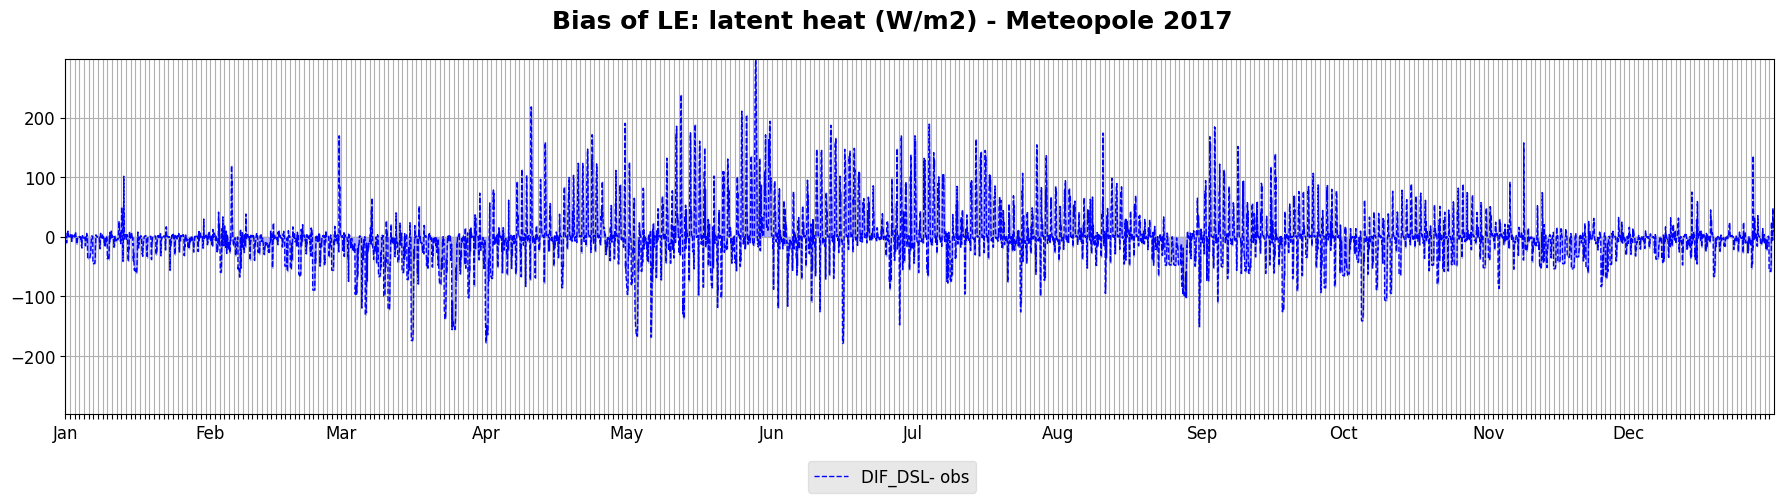

In [26]:
campo = 5 # posición en field_vars lo voy a hacer para que por ahora salga de uno en uno (H=4)
add_forc = False # añadir o no un forzamiento
forzamiento = 10 # se podría hacer para otro forzamiento más pero no lo recomiendo, porque sería tener 3 ejes y en una misma gráfica (Forc_RAIN=3)
experiments = [1] #, 2, 3] # Posiciones. Por si no quiero representarlos todos
# exps = ['DIF_REF', 'DIF_DSL', 'MEB_REF', 'MEB_DSL']

month_interv = [1, 12] # Intervalo de meses (Enero = 1). Ambos inclusive
# day_interv = [1, 15] # ESTÁ PENDIENTE, hacer para dentro de un solo mes supongo? por ahora

observation = True # Para ver o no las observaciones de H y LE
corrected = False # Para ver las observaciones con o sin corrección (ojo, no tengo los correctad en horario)

# graph_type = 'diario'
graph_type = 'horario'
# graph_type = 'diario acumulado'


########## Ahora ya la figura, esto no se debería necesitar editar:
meses = [calendar.month_abbr[i] for i in range(1, 13)] + ['Jan']
dias_por_mes = [calendar.monthrange(2017, i)[1] for i in range(1, 13)] 
dias_por_mes.insert(0, 0)

if graph_type == 'diario':
  posiciones_meses = np.cumsum(dias_por_mes)
  y1 = MPOLE_daily
  y2 = MPOLE_MOD_daily
  y3 = MPOLE_closing_daily
elif graph_type == 'horario':
  posiciones_meses = np.cumsum(dias_por_mes)*24
  y1 = MPOLE_hours
  y2 = MPOLE_MOD_hours
elif graph_type == 'diario acumulado':
  posiciones_meses = np.cumsum(dias_por_mes)
  y1 = MPOLE_daily_sum
  y2 = MPOLE_MOD_daily_sum
  y3 = MPOLE_closing_daily_sum

fig, ax1 = plt.subplots(figsize=(18,5))

if add_forc == True:
  ax2 = ax1.twinx()
  ax2.set_ylabel(forcing_vars[forzamiento]+'  ('+forcing_units[forzamiento]+')')
  ax2.plot(y2[forcing_vars[forzamiento]].values, color=colors[6], label=forcing_vars[forzamiento], linewidth=0.5)
  ax2.fill_between(np.arange(0,len(y2)),y2[forcing_vars[forzamiento]].values, color=colors[6], alpha=0.3)
  ax2.set_ylim([np.min(y2[forcing_vars[forzamiento]].values), np.max(y2[forcing_vars[forzamiento]].values)]) ### a ver si me convence
ax1.grid(True)

minimos, maximos = [], []
if corrected == False and field_vars[campo] in my_dict:
  for exp in experiments:
    ax1.plot(y1[field_vars[campo]+'_'+exps[exp]].values - y1[my_dict[field_vars[campo]]].values,
             label=exps[exp]+'- obs', color=colors[exp], linestyle=styles[exp], linewidth=1)
    ax1.fill_between(np.arange(0,len(y2)), y1[field_vars[campo]+'_'+exps[exp]].values - y1[my_dict[field_vars[campo]]].values, color=colors[exp], alpha=0.3)
    minimos.append(np.min(y1[field_vars[campo]+'_'+exps[exp]].values - y1[my_dict[field_vars[campo]]].values))
    maximos.append(np.max(y1[field_vars[campo]+'_'+exps[exp]].values - y1[my_dict[field_vars[campo]]].values))
elif corrected == True and graph_type != 'horario':
    for exp in experiments:
      ax1.plot(y1[field_vars[campo]+'_'+exps[exp]].values - y3[field_vars[campo]+'_corrected'].values,
             label=exps[exp]+'- obs_cor',color=colors[5],linestyle=styles[5]) 
      ax1.fill_between(np.arange(0,len(y2)), y1[field_vars[campo]+'_'+exps[exp]].values - y3[field_vars[campo]+'_corrected'].values, color=colors[exp], alpha=0.3)
      minimos.append(np.min(y1[field_vars[campo]+'_'+exps[exp]].values - y3[field_vars[campo]+'_corrected'].values))
      maximos.append(np.max(y1[field_vars[campo]+'_'+exps[exp]].values - y3[field_vars[campo]+'_corrected'].values))


max_absoluto = max(max(abs(x) for x in minimos), max(abs(x) for x in maximos))
ax1.set_ylim([-max_absoluto, max_absoluto])
# ax1.set_ylim([np.min(minimos), np.max(maximos)])
fig.legend(facecolor='lightgray',framealpha=0.5, ncol=6, loc='lower center')
fig.suptitle('Bias of '+field_vars[campo]+': '+field_names[campo]+' ('+field_units[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(bottom=0.17)

plt.xticks(posiciones_meses, meses)

if graph_type == 'horario':
  plt.xticks(np.arange(0,365)*24)

plt.xlim([posiciones_meses[month_interv[0] - 1], posiciones_meses[month_interv[1]]]) # Esto para sacar meses concretos


plt.show()
plt.close()

# PROYECTO "SESGOS 2.0":

c:\Users\begon\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


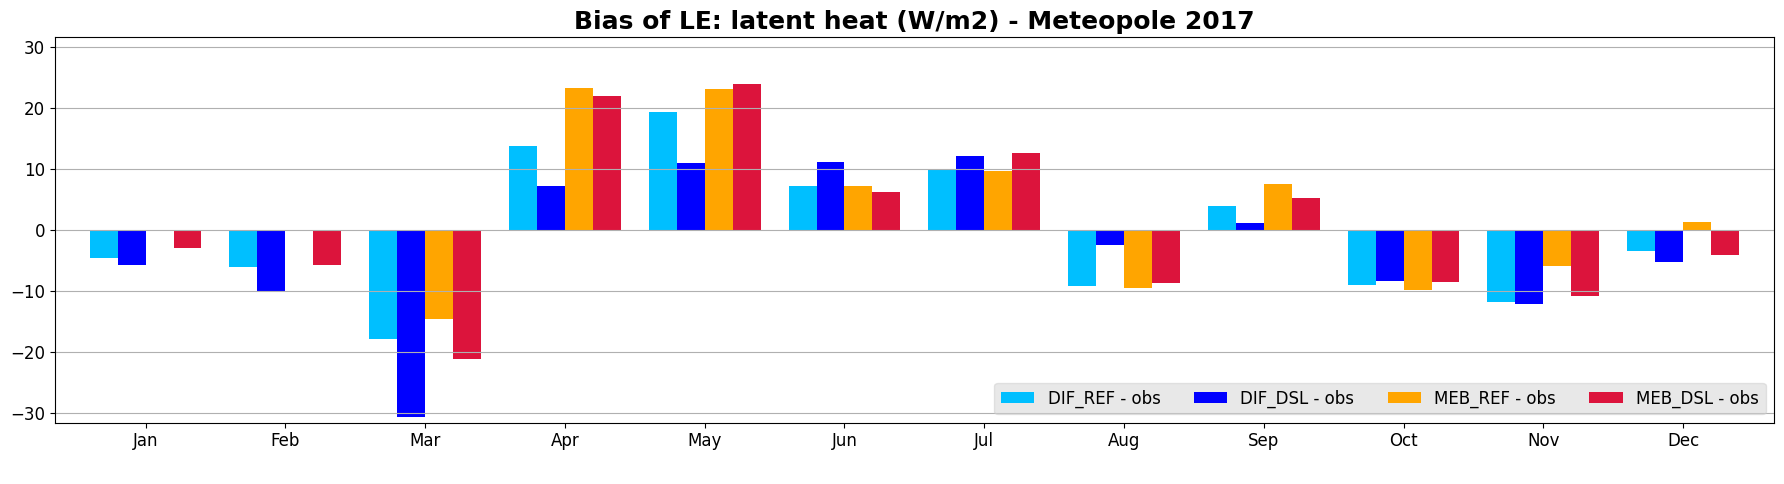

In [27]:
campo = 5

dif_ref = MPOLE_hours[field_vars[campo]+'_'+exps[0]] - MPOLE_hours[my_dict[field_vars[campo]]]
dif_dsl = MPOLE_hours[field_vars[campo]+'_'+exps[1]] - MPOLE_hours[my_dict[field_vars[campo]]]
meb_ref = MPOLE_hours[field_vars[campo]+'_'+exps[2]] - MPOLE_hours[my_dict[field_vars[campo]]]
meb_dsl = MPOLE_hours[field_vars[campo]+'_'+exps[3]] - MPOLE_hours[my_dict[field_vars[campo]]]

data = {
    'Categorías': meses[:-1],
    'DIF_REF - obs': dif_ref.groupby(level=0).mean().values,
    'DIF_DSL - obs': dif_dsl.groupby(level=0).mean().values,
    'MEB_REF - obs': meb_ref.groupby(level=0).mean().values,
    'MEB_DSL - obs': meb_dsl.groupby(level=0).mean().values
}

data2 = {
    'Categorías': meses[:-1],
    '|DIF_REF - obs|': abs(dif_ref.groupby(level=0).mean().values),
    '|DIF_DSL - obs|': abs(dif_dsl.groupby(level=0).mean().values),
    '|MEB_REF - obs|': abs(meb_ref.groupby(level=0).mean().values),
    '|MEB_DSL - obs|': abs(meb_dsl.groupby(level=0).mean().values)
}

# Crear un DataFrame
df = pd.DataFrame(data)
df2 = pd.DataFrame(data2)

# Establecer la columna de categorías como índice
df.set_index('Categorías', inplace=True)

ax = df.plot(kind='bar', figsize=(18,5), color=colors, width=0.8)
ax.set_xlabel(' ')
# ax.set_ylabel('Valores')

plt.xticks(rotation=0)
plt.ylim([-np.max(np.max(abs(df)).values)-1, np.max(np.max(abs(df)).values+1)])

plt.legend(facecolor='lightgray',framealpha=0.5, ncol=6, loc='lower right')
ax.set_title('Bias of '+field_vars[campo]+': '+field_names[campo]+' ('+field_units[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(bottom=0.17)
plt.grid(axis='y')

plt.show()

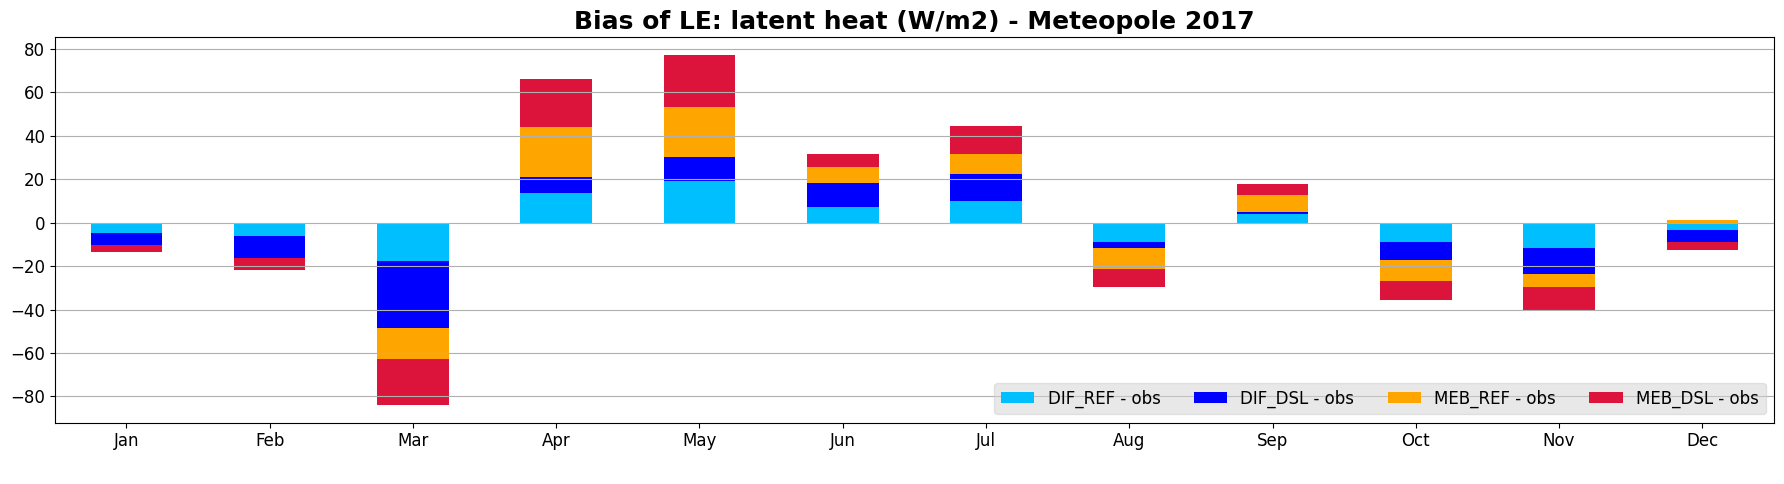

In [28]:
campo = 5

dif_ref = MPOLE_hours[field_vars[campo]+'_'+exps[0]] - MPOLE_hours[my_dict[field_vars[campo]]]
dif_dsl = MPOLE_hours[field_vars[campo]+'_'+exps[1]] - MPOLE_hours[my_dict[field_vars[campo]]]
meb_ref = MPOLE_hours[field_vars[campo]+'_'+exps[2]] - MPOLE_hours[my_dict[field_vars[campo]]]
meb_dsl = MPOLE_hours[field_vars[campo]+'_'+exps[3]] - MPOLE_hours[my_dict[field_vars[campo]]]

data = {
    'Categorías': meses[:-1],
    'DIF_REF - obs': dif_ref.groupby(level=0).mean().values,
    'DIF_DSL - obs': dif_dsl.groupby(level=0).mean().values,
    'MEB_REF - obs': meb_ref.groupby(level=0).mean().values,
    'MEB_DSL - obs': meb_dsl.groupby(level=0).mean().values
}

data2 = {
    'Categorías': meses[:-1],
    '|DIF_REF - obs|': abs(dif_ref.groupby(level=0).mean().values),
    '|DIF_DSL - obs|': abs(dif_dsl.groupby(level=0).mean().values),
    '|MEB_REF - obs|': abs(meb_ref.groupby(level=0).mean().values),
    '|MEB_DSL - obs|': abs(meb_dsl.groupby(level=0).mean().values)
}

# Crear un DataFrame
df = pd.DataFrame(data)
df2 = pd.DataFrame(data2)

# Establecer la columna de categorías como índice
df.set_index('Categorías', inplace=True)

ax = df.plot(kind='bar', figsize=(18,5), color=colors, stacked='True', width=0.5)
ax.set_xlabel(' ')
# ax.set_ylabel('Valores')

plt.xticks(rotation=0)
# plt.ylim([-np.max(np.max(abs(df)).values)-1, np.max(np.max(abs(df)).values+1)])

plt.legend(facecolor='lightgray',framealpha=0.5, ncol=6, loc='lower right')
ax.set_title('Bias of '+field_vars[campo]+': '+field_names[campo]+' ('+field_units[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(bottom=0.17)
plt.grid(axis='y')

plt.show()

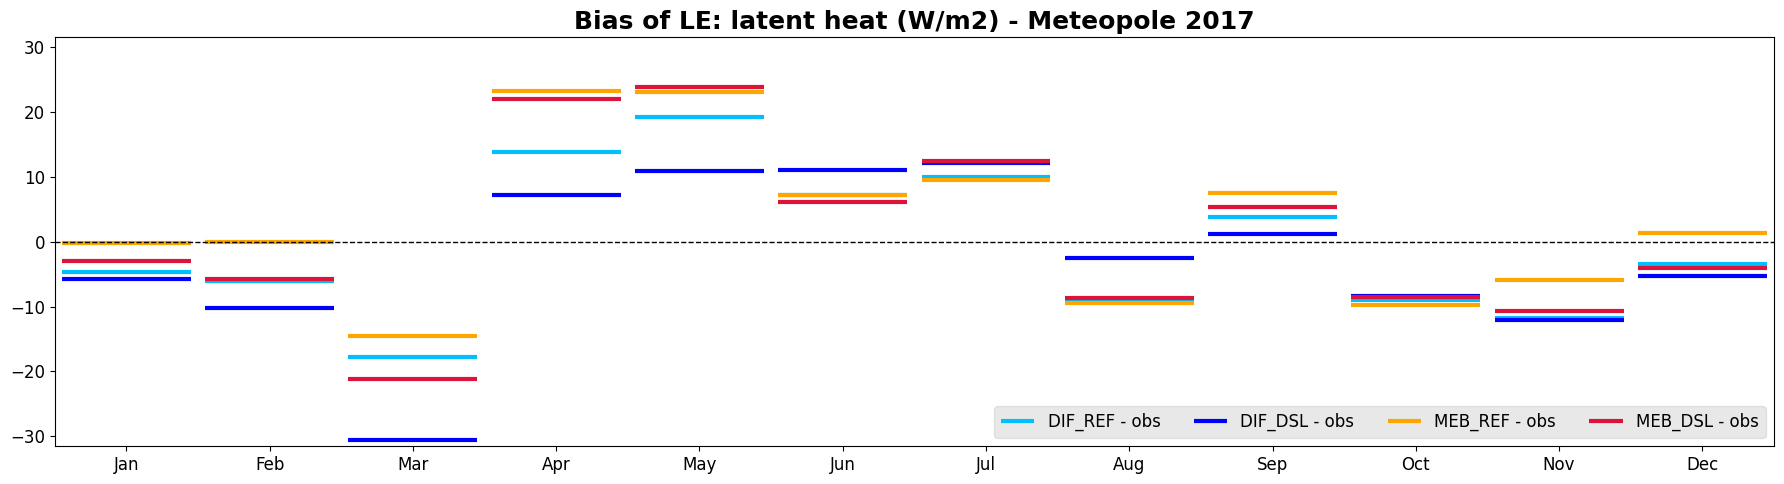

In [29]:
campo = 5

dif_ref = MPOLE_hours[field_vars[campo]+'_'+exps[0]] - MPOLE_hours[my_dict[field_vars[campo]]]
dif_dsl = MPOLE_hours[field_vars[campo]+'_'+exps[1]] - MPOLE_hours[my_dict[field_vars[campo]]]
meb_ref = MPOLE_hours[field_vars[campo]+'_'+exps[2]] - MPOLE_hours[my_dict[field_vars[campo]]]
meb_dsl = MPOLE_hours[field_vars[campo]+'_'+exps[3]] - MPOLE_hours[my_dict[field_vars[campo]]]

series1 = dif_ref.groupby(level=0).mean().values
series2 = dif_dsl.groupby(level=0).mean().values
series3 = meb_ref.groupby(level=0).mean().values
series4 = meb_dsl.groupby(level=0).mean().values

data = {
    'Categorías': meses[:-1],
    'DIF_REF - obs': series1,
    'DIF_DSL - obs': series2,
    'MEB_REF - obs': series3,
    'MEB_DSL - obs': series4
}

data2 = {
    'Categorías': meses[:-1],
    '|DIF_REF - obs|': abs(series1),
    '|DIF_DSL - obs|': abs(series2),
    '|MEB_REF - obs|': abs(series3),
    '|MEB_DSL - obs|': abs(series4)
}

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(18, 5))

x = np.arange(len(meses[:-1]))

dx = 0.45

# Añadir líneas horizontales para cada serie en cada mes
ax.hlines(series1, x - dx, x + dx, color=colors[0], label='DIF_REF - obs', lw=3)
ax.hlines(series2, x - dx, x + dx, color=colors[1], label='DIF_DSL - obs', lw=3)
ax.hlines(series3, x - dx, x + dx, color=colors[2], label='MEB_REF - obs', lw=3)
ax.hlines(series4, x - dx, x + dx, color=colors[3], label='MEB_DSL - obs', lw=3)

ax.axhline(0, color='black', linestyle='--', linewidth=1)

ax.set_title('Comparación de 4 series con líneas horizontales')
ax.set_xticks(x)
ax.set_xticklabels(meses[:-1])

all_series = np.hstack((series1, series2, series3, series4))

plt.xlim([-0.5,11.5])
plt.ylim([-np.max(abs(all_series))-1, np.max(abs(all_series))+1])

plt.legend(facecolor='lightgray',framealpha=0.5, ncol=6, loc='lower right')
ax.set_title('Bias of '+field_vars[campo]+': '+field_names[campo]+' ('+field_units[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

In [30]:
print('media 1:', np.mean(abs(series1)))
print('suma 1:', np.sum(abs(series1)))
print('')
print('media 2:', np.mean(abs(series2)))
print('suma 2:', np.sum(abs(series2)))
print('')
print('media 3:', np.mean(abs(series3)))
print('suma 3:', np.sum(abs(series3)))
print('')
print('media 4:', np.mean(abs(series4)))
print('suma 4:', np.sum(abs(series4)))

media 1: 9.665748173168312
suma 1: 115.98897807801976

media 2: 9.755200843213517
suma 2: 117.06241011856221

media 3: 9.330806371951983
suma 3: 111.9696764634238

media 4: 10.990977340434894
suma 4: 131.89172808521872


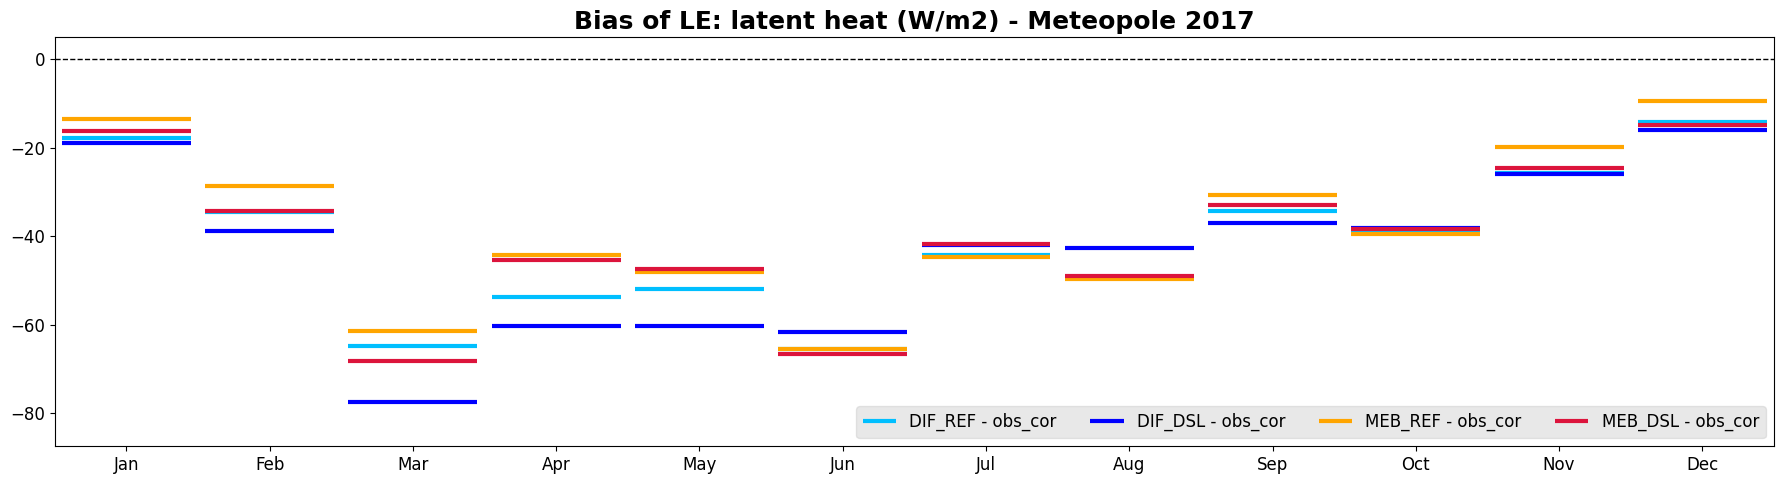

In [31]:
campo = 5

dif_ref = MPOLE_daily[field_vars[campo]+'_'+exps[0]] - MPOLE_closing_daily[field_vars[campo]+'_corrected']
dif_dsl = MPOLE_daily[field_vars[campo]+'_'+exps[1]] - MPOLE_closing_daily[field_vars[campo]+'_corrected']
meb_ref = MPOLE_daily[field_vars[campo]+'_'+exps[2]] - MPOLE_closing_daily[field_vars[campo]+'_corrected']
meb_dsl = MPOLE_daily[field_vars[campo]+'_'+exps[3]] - MPOLE_closing_daily[field_vars[campo]+'_corrected']

series1 = dif_ref.groupby(level=0).mean().values
series2 = dif_dsl.groupby(level=0).mean().values
series3 = meb_ref.groupby(level=0).mean().values
series4 = meb_dsl.groupby(level=0).mean().values

data = {
    'Categorías': meses[:-1],
    'DIF_REF - obs': series1,
    'DIF_DSL - obs': series2,
    'MEB_REF - obs': series3,
    'MEB_DSL - obs': series4
}

data2 = {
    'Categorías': meses[:-1],
    '|DIF_REF - obs|': abs(series1),
    '|DIF_DSL - obs|': abs(series2),
    '|MEB_REF - obs|': abs(series3),
    '|MEB_DSL - obs|': abs(series4)
}

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(18, 5))

x = np.arange(len(meses[:-1]))

dx = 0.45

# Añadir líneas horizontales para cada serie en cada mes
ax.hlines(series1, x - dx, x + dx, color=colors[0], label='DIF_REF - obs_cor', lw=3)
ax.hlines(series2, x - dx, x + dx, color=colors[1], label='DIF_DSL - obs_cor', lw=3)
ax.hlines(series3, x - dx, x + dx, color=colors[2], label='MEB_REF - obs_cor', lw=3)
ax.hlines(series4, x - dx, x + dx, color=colors[3], label='MEB_DSL - obs_cor', lw=3)

ax.axhline(0, color='black', linestyle='--', linewidth=1)

ax.set_title('Comparación de 4 series con líneas horizontales')
ax.set_xticks(x)
ax.set_xticklabels(meses[:-1])

all_series = np.hstack((series1, series2, series3, series4))

plt.xlim([-0.5,11.5])
plt.ylim([-np.max(abs(all_series))-10, 5])

plt.legend(facecolor='lightgray',framealpha=0.5, ncol=6, loc='lower right')
ax.set_title('Bias of '+field_vars[campo]+': '+field_names[campo]+' ('+field_units[campo]+') - Meteopole 2017', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

In [32]:
print('media 1:', np.mean(abs(series1)))
print('suma 1:', np.sum(abs(series1)))
print('')
print('media 2:', np.mean(abs(series2)))
print('suma 2:', np.sum(abs(series2)))
print('')
print('media 3:', np.mean(abs(series3)))
print('suma 3:', np.sum(abs(series3)))
print('')
print('media 4:', np.mean(abs(series4)))
print('suma 4:', np.sum(abs(series4)))

media 1: 41.18392194259331
suma 1: 494.2070633111197

media 2: 43.220322990438085
suma 2: 518.643875885257

media 3: 37.88707745926674
suma 3: 454.6449295112009

media 4: 39.89835199628409
suma 4: 478.7802239554091
